# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon
This notebook is a template with each step that you need to complete for the project.

Please fill in your code where there are explicit `?` markers in the notebook. You are welcome to add more cells and code as you see fit.

Once you have completed all the code implementations, please export your notebook as a HTML file so the reviews can view your code. Make sure you have all outputs correctly outputted.

`File-> Export Notebook As... -> Export Notebook as HTML`

There is a writeup to complete as well after all code implememtation is done. Please answer all questions and attach the necessary tables and charts. You can complete the writeup in either markdown or PDF.

Completing the code template and writeup template will cover all of the rubric points for this project.

The rubric contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this notebook and also discuss the results in the writeup file.

## Step 1: Create an account with Kaggle

### Create Kaggle Account and download API key
Below is example of steps to get the API username and key. Each student will have their own username and key.

1. Open account settings.
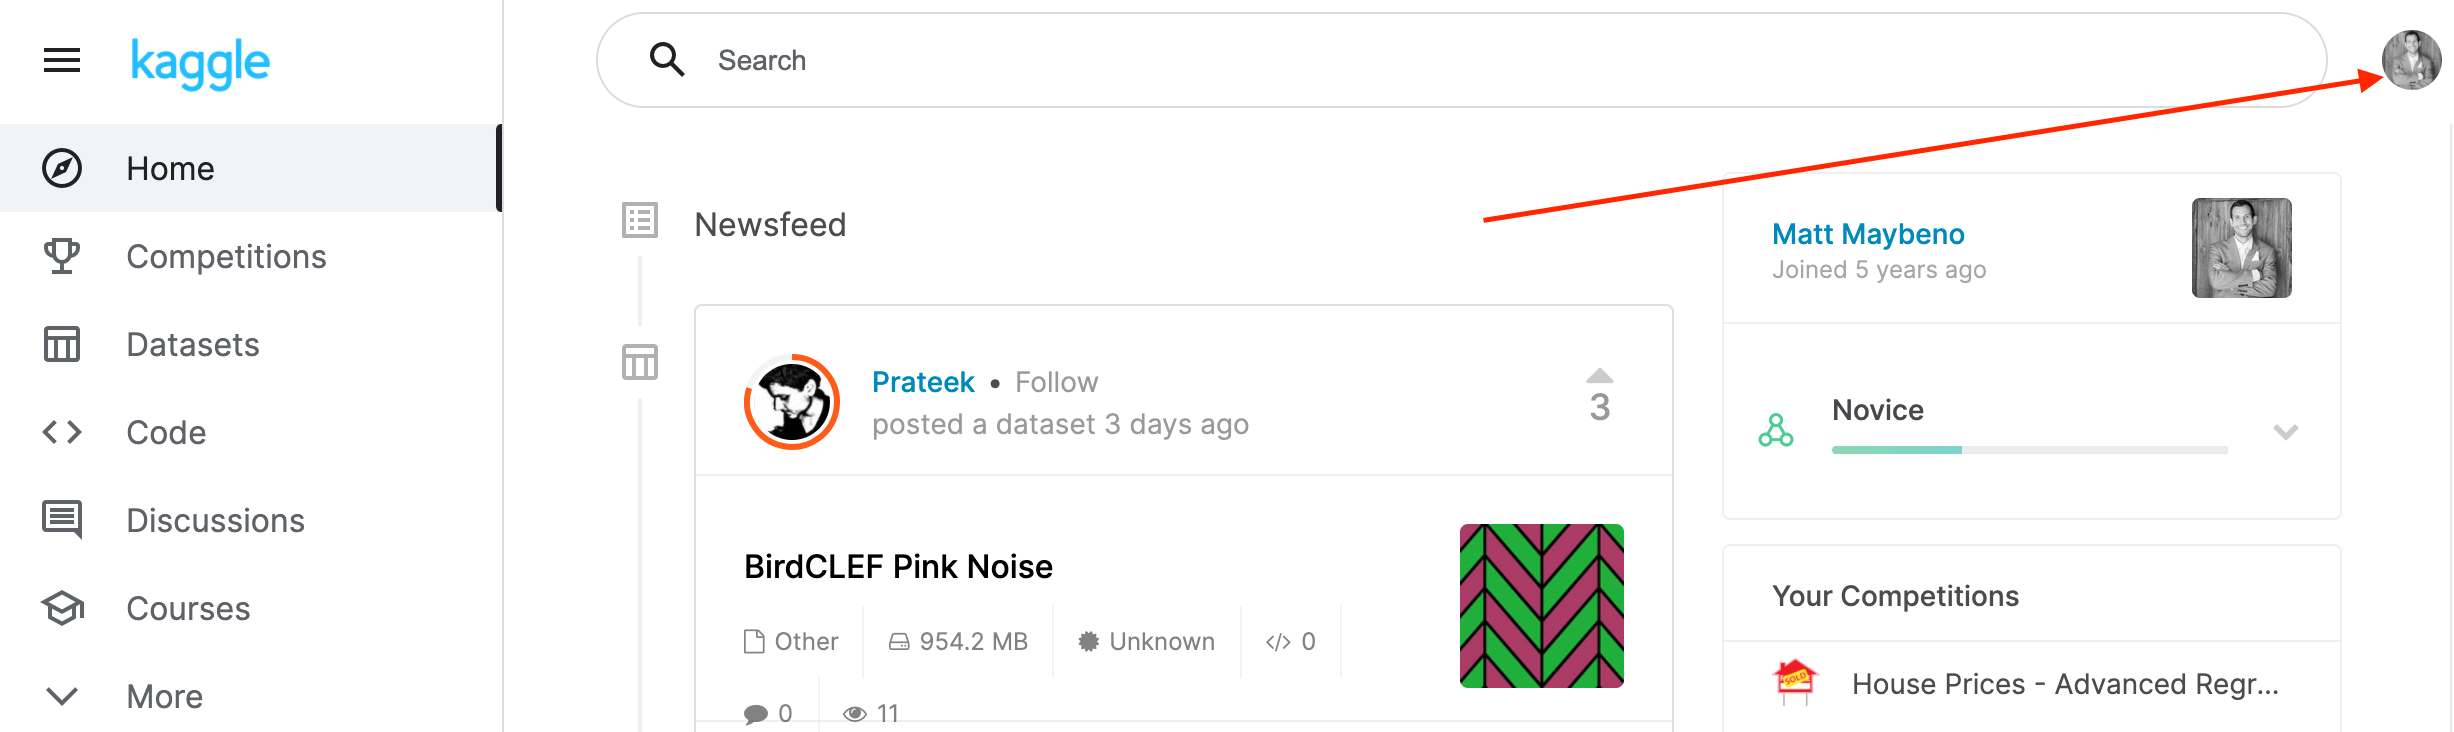
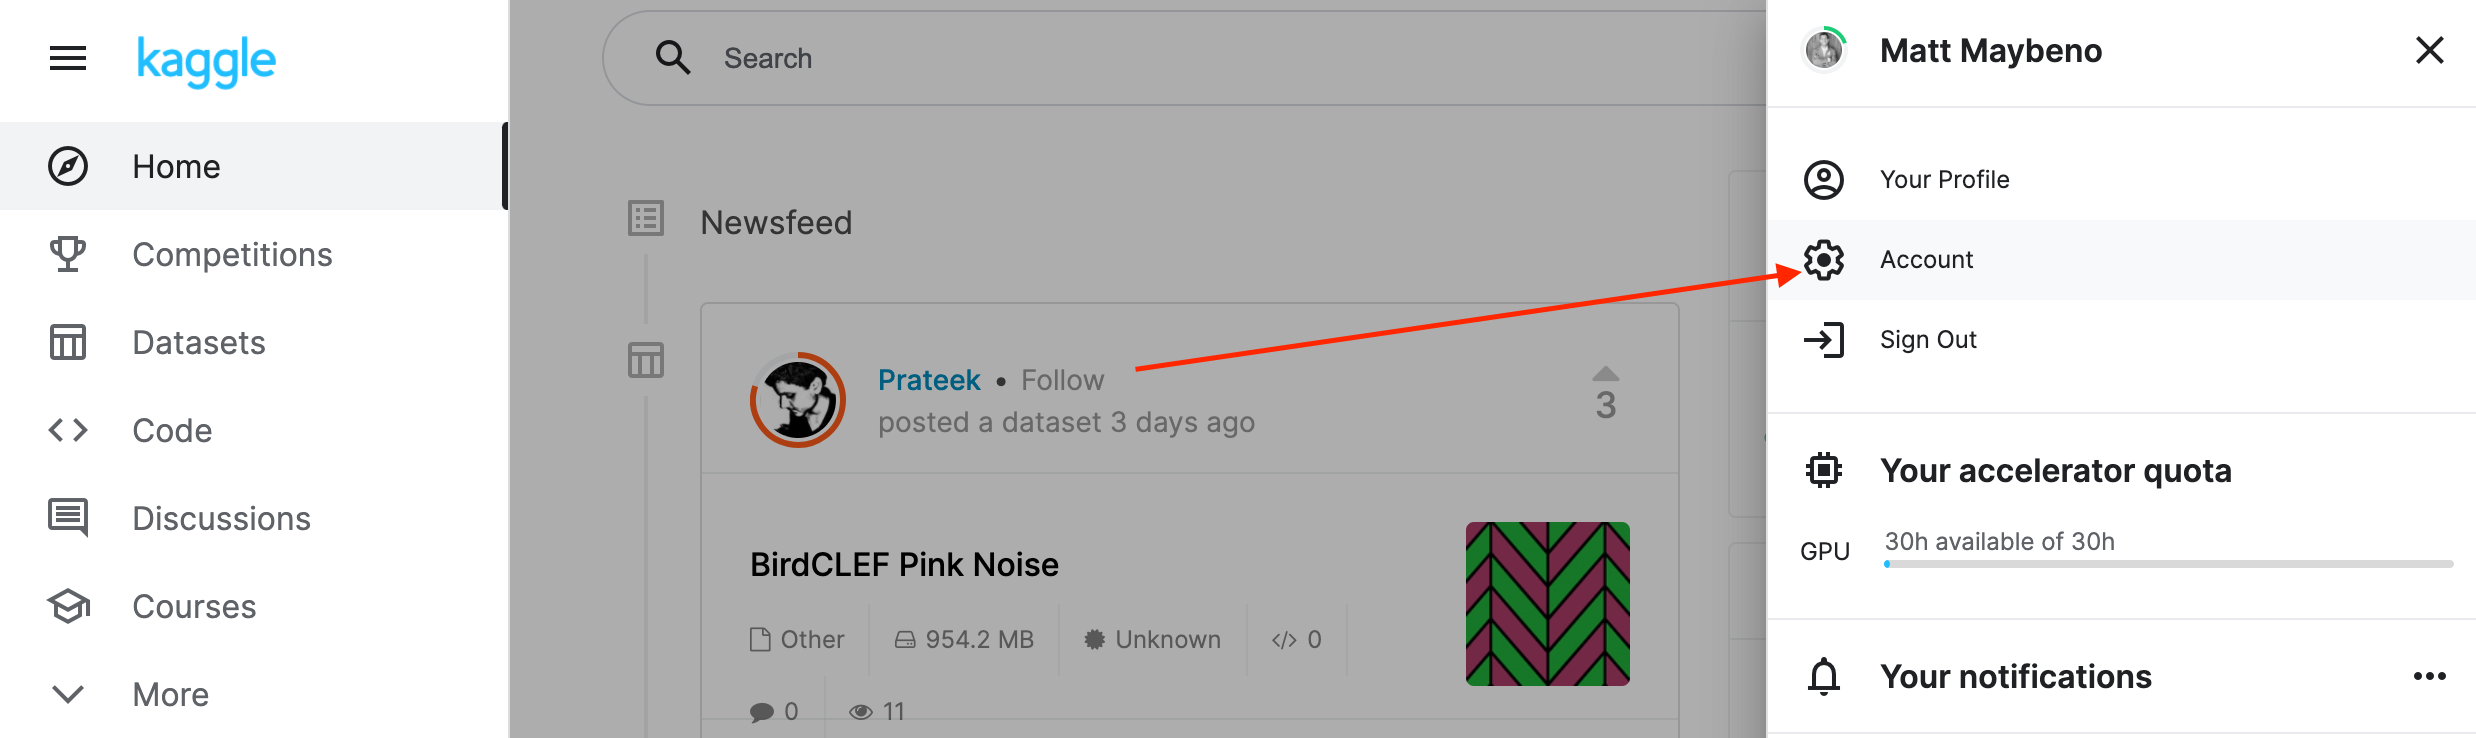
2. Scroll down to API and click Create New API Token.
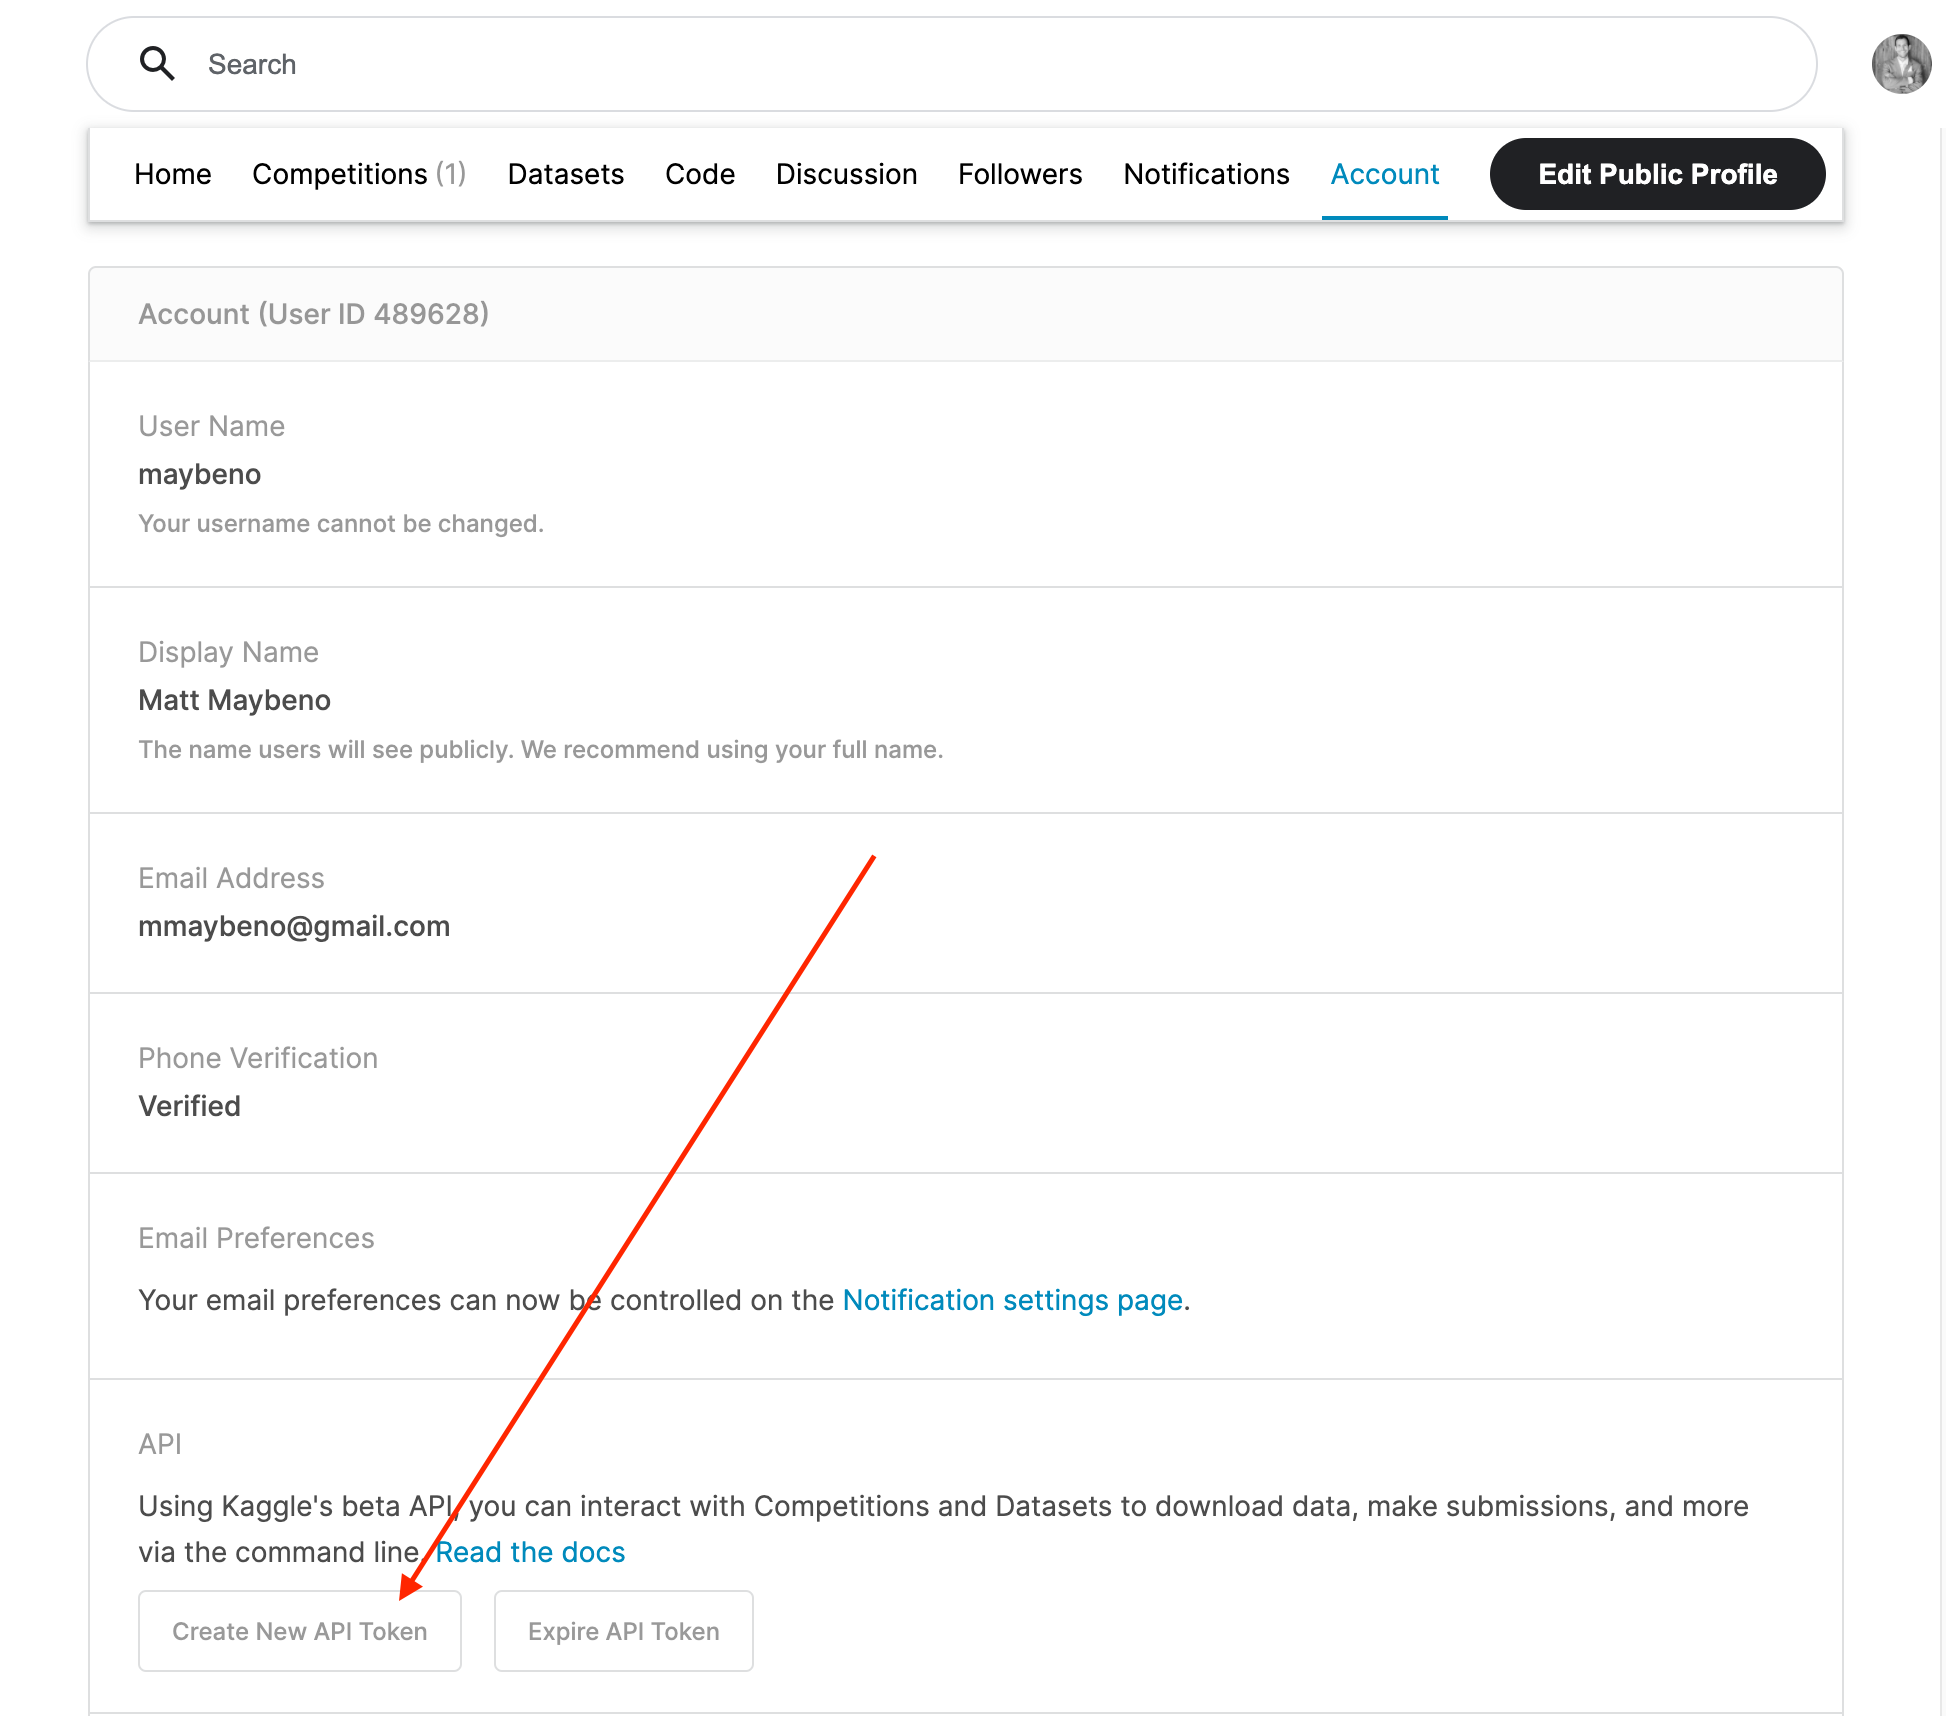
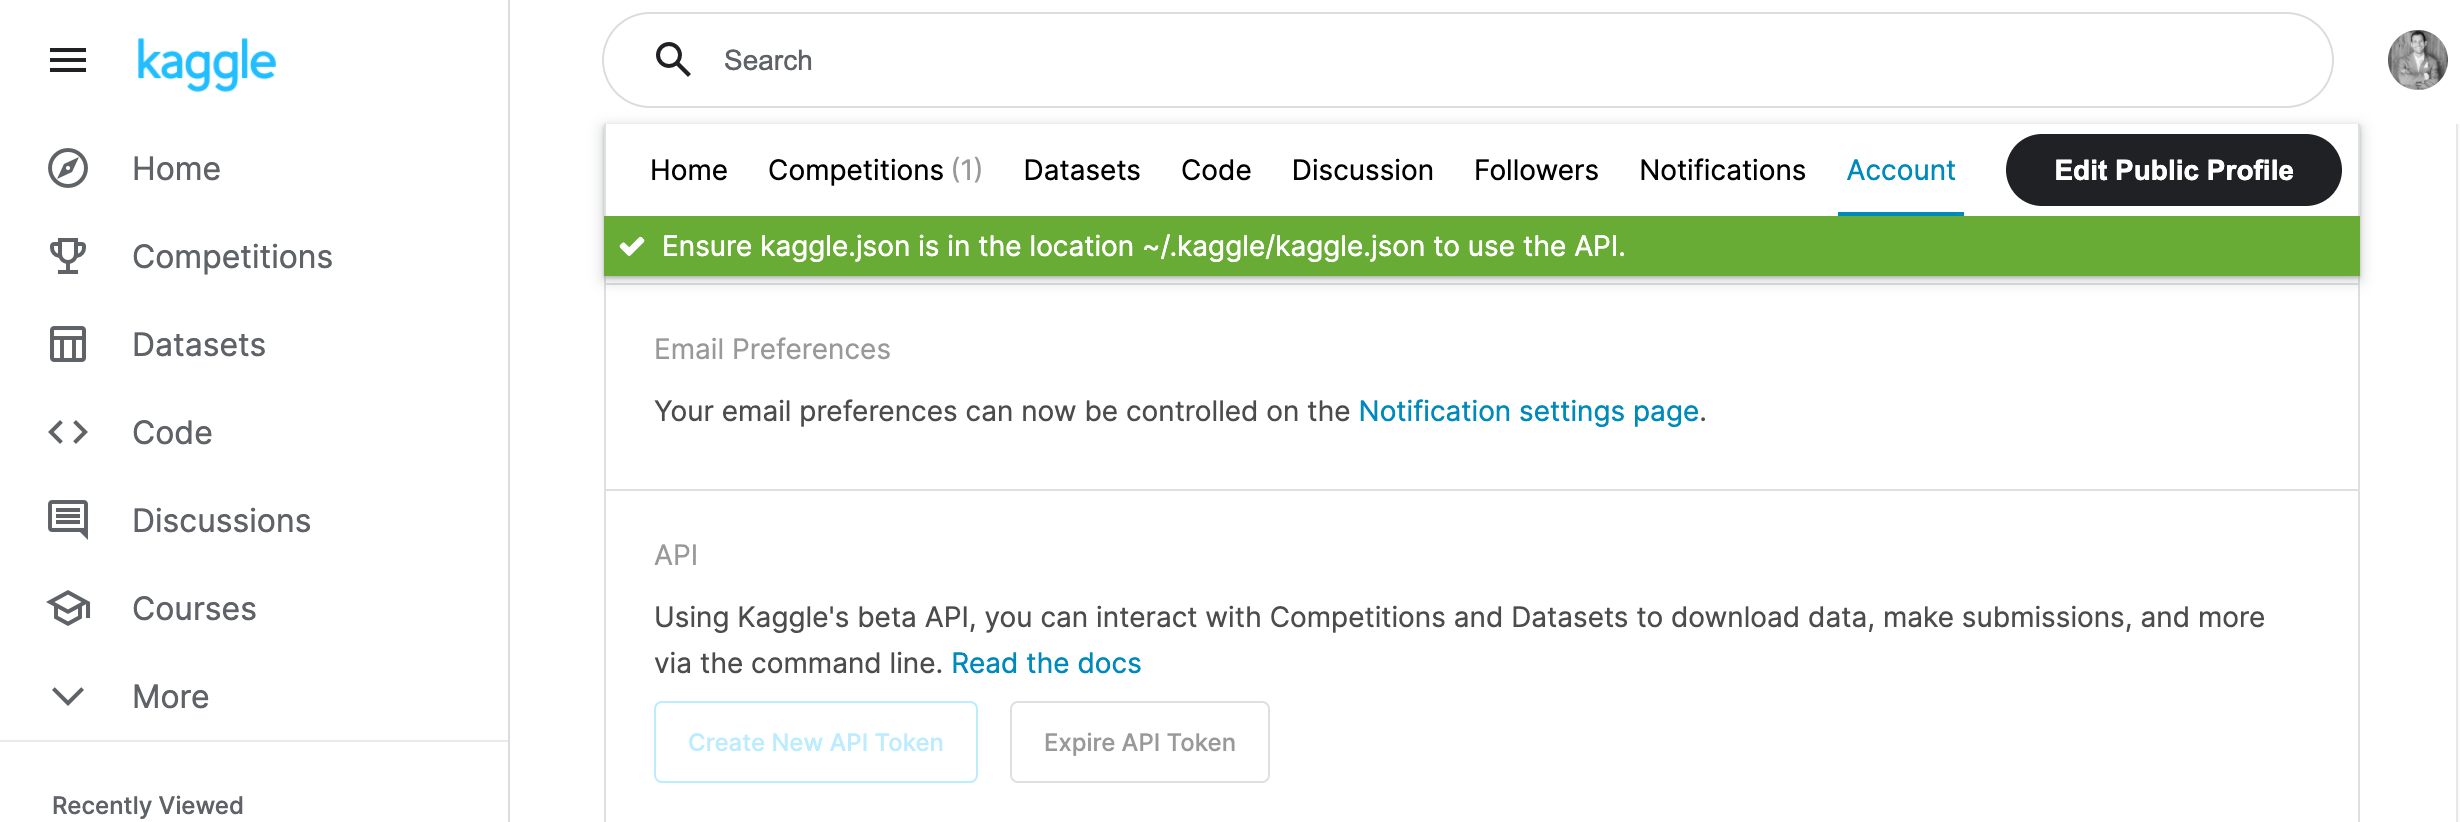
3. Open up `kaggle.json` and use the username and key.
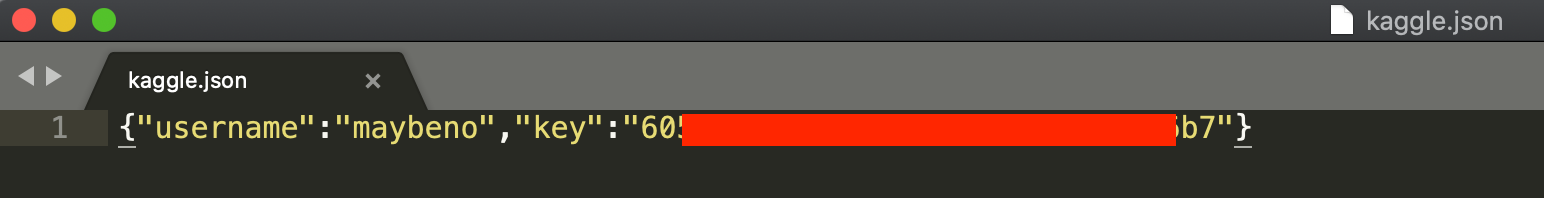

## Step 2: Download the Kaggle dataset using the kaggle python library

### Open up Sagemaker Studio and use starter template

1. Notebook should be using a `ml.t3.medium` instance (2 vCPU + 4 GiB)
2. Notebook should be using kernal: `Python 3 (MXNet 1.8 Python 3.7 CPU Optimized)`

### Install packages

In [1]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-25.3-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.3-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.2
    Uninstalling pip-25.2:
      Successfully uninstalled pip-25.2
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl.metadata (3.4 kB)
  Using cached bokeh-2.0.1.tar.gz (8.6 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      /tmp/pip-install-2rka8jb9/bokeh_0e63f3deca7c44409ff3eb4459b49b3c/versioneer.py:416: SyntaxWarning: invalid escape sequence '\s'
        LONG_VERSION_PY['git'] = '''
      Traceback (most recent call last):
        File "/opt/conda/lib/python3.12/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
        File "/opt/conda/lib/pyt

### Setup Kaggle API Key

### Download and explore dataset

In [8]:
# Create a kaggle directory
!mkdir -p ~/.kaggle # Using -p ensures no error if the directory already exists

# Copy 'kaggle.json' (Kaggle API Token) to the folder we have created
!cp kaggle.json ~/.kaggle/

# Authorize permissions for the json to act
!chmod 600 ~/.kaggle/kaggle.json

# Download the Bike Sharing Demand dataset
!kaggle competitions download -c bike-sharing-demand

# Unzip Dataset
!unzip -o bike-sharing-demand.zip

# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 19.9MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               
bike-sharing-demand.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


### Go to the bike sharing demand competition and agree to the terms
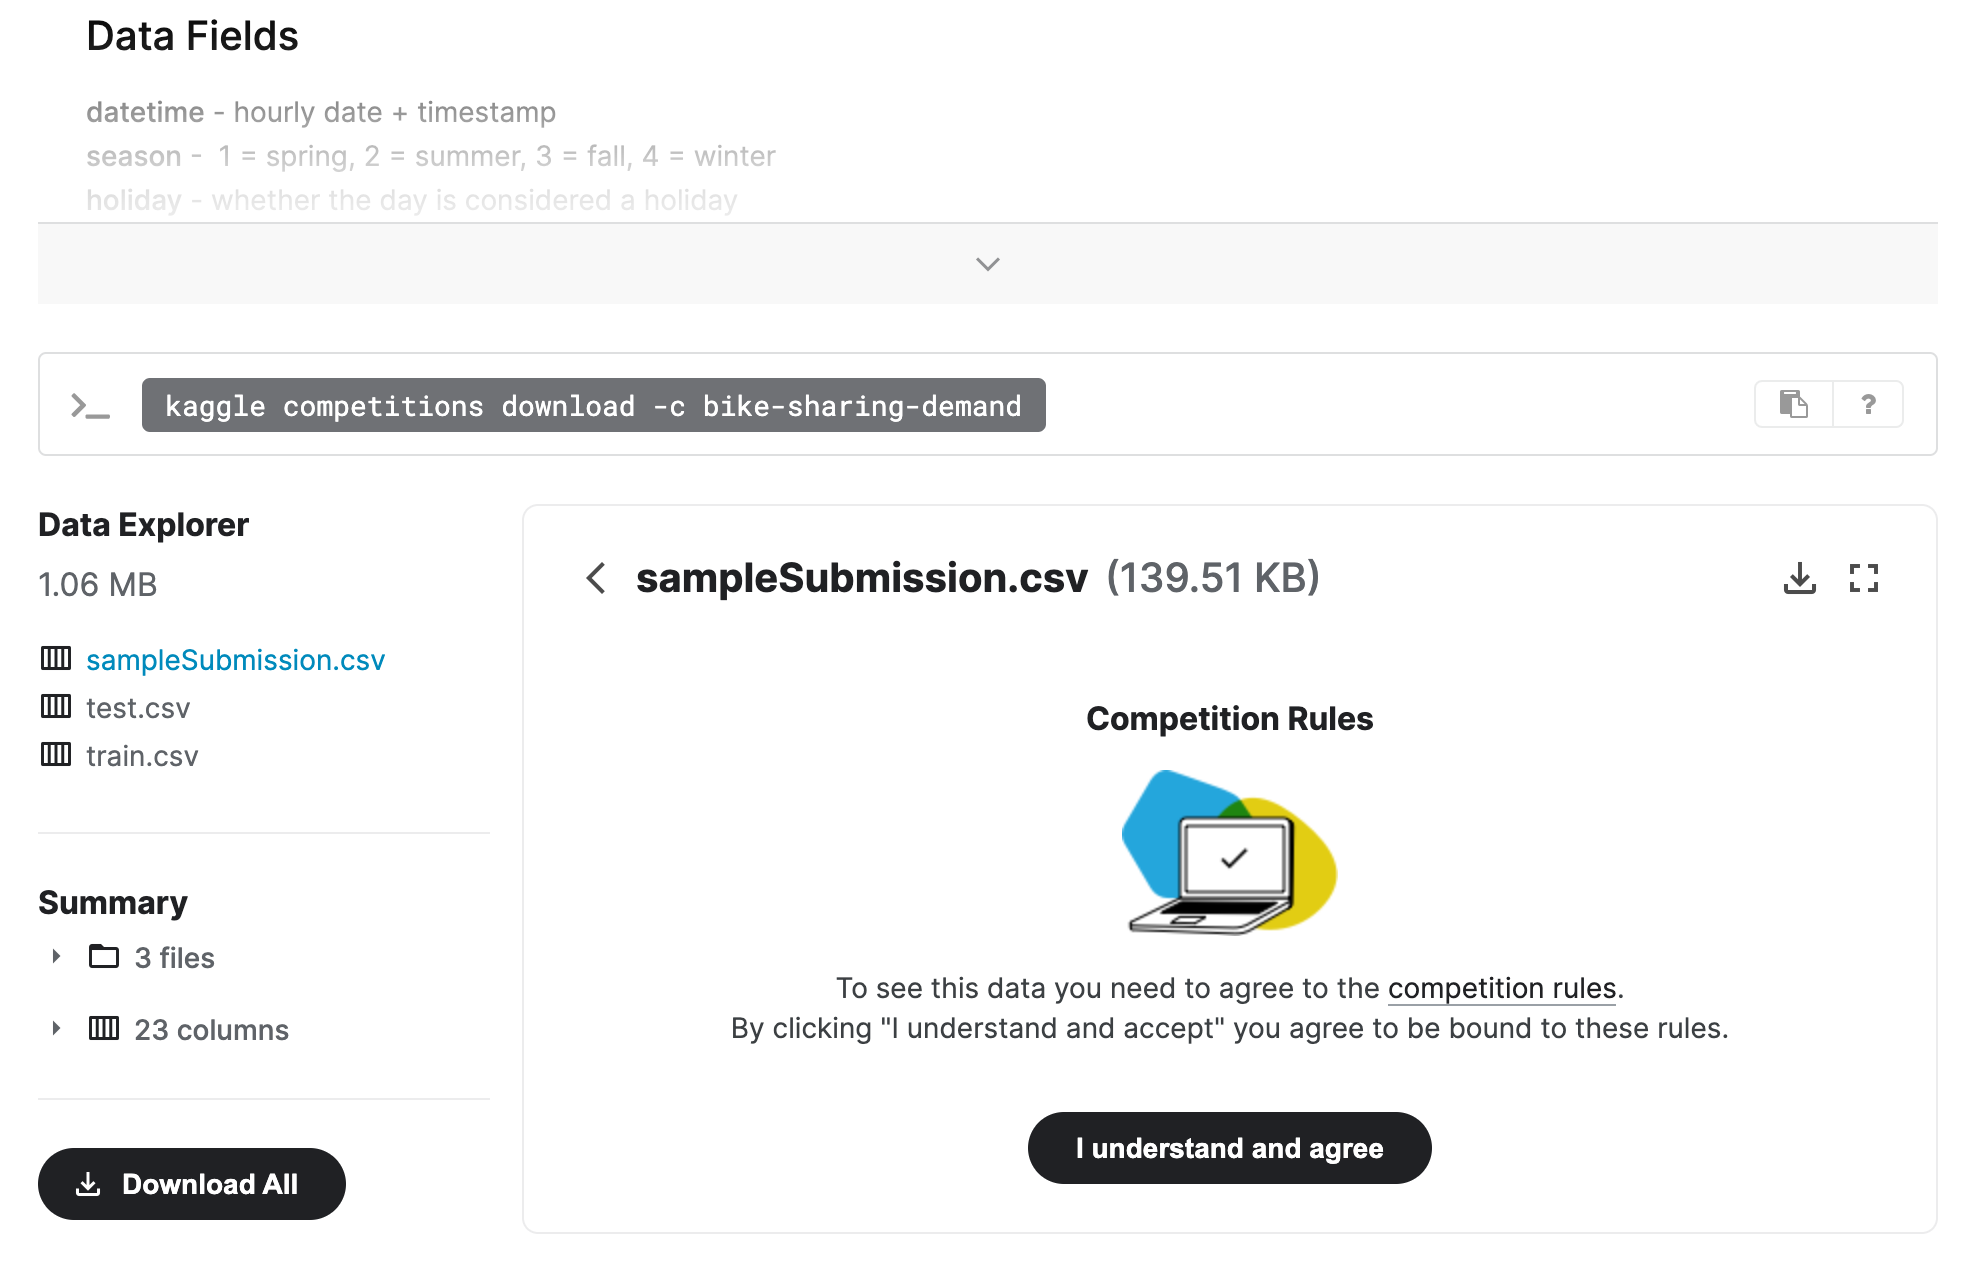

In [10]:
import numpy as np
import pandas as pd
from autogluon.tabular import TabularPredictor

In [11]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv",parse_dates=["datetime"])
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [12]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
# Train dataset summary
train.describe()

datetime        season       holiday  \
count                          10886  10886.000000  10886.000000   
mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
min              2011-01-01 00:00:00      1.000000      0.000000   
25%              2011-07-02 07:15:00      2.000000      0.000000   
50%              2012-01-01 20:30:00      3.000000      0.000000   
75%              2012-07-01 12:45:00      4.000000      0.000000   
max              2012-12-19 23:00:00      4.000000      1.000000   
std                              NaN      1.116174      0.166599   

         workingday       weather         temp         atemp      humidity  \
count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
mean       0.680875      1.418427     20.23086     23.655084     61.886460   
min        0.000000      1.000000      0.82000      0.760000      0.000000   
25%        0.000000      1.000000     13.94000     16.665000     47.000000   
50%        1.000000      1.000000     20.50000     24.240000     62.000000   
75%        1.000000      2.000000     26.24000     31.060000     77.000000   
max        1.000000      4.000000     41.00000     45.455000    100.000000   
std        0.466159      0.633839      7.79159      8.474601     19.245033   

          windspeed        casual    registered         count  
count  10886.000000  10886.000000  10886.000000  10886.000000  
mean      12.799395     36.021955    155.552177    191.574132  
min        0.000000      0.000000      0.000000      1.000000  
25%        7.001500      4.000000     36.000000     42.000000  
50%       12.998000     17.000000    118.000000    145.000000  
75%       16.997900     49.000000    222.000000    284.000000  
max       56.996900    367.000000    886.000000    977.000000  
std        8.164537     49.960477    151.039033    181.144454

In [13]:
# Information of the feature datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [15]:
# Check for the count of missing values
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [16]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("test.csv",parse_dates=["datetime"])
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0 2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1 2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2 2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3 2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4 2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

In [17]:
# Similar Check for the count of missing values in test data
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [18]:
# Shape of the train and test data
print("Train Shape : ", train.shape)
print("Test Shape  : ", test.shape)

Train Shape :  (10886, 12)
Test Shape  :  (6493, 9)


In [22]:
# List all the features in train and test data to identify features that can be safely removed
print("Features in Training data:\n", train.columns)
print("\nFeatures in Testing data:\n", test.columns)

Features in Training data:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

Features in Testing data:
 Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


In [23]:
# Thus missing features are
print("Missing features are")
list(set(train.columns).difference(set(test.columns)))

Missing features are


['count', 'registered', 'casual']

### Dataset Dictionary
**temp** - temperature in Celsius<br>
**atemp** - "feels like" temperature in Celsius<br>
**humidity** - relative humidity<br>
**windspeed** - wind speed<br>
**casual** - number of non-registered user rentals initiated (removed)<br>
**registered** - number of registered user rentals initiated (removed)<br>
**count** - number of total rentals<br>
**datetime** - hourly date + timestamp<br>
**season** - 1 = spring, 2 = summer, 3 = fall, 4 = winter<br>
**holiday** - whether the day is considered a holiday<br>
**workingday** - whether the day is neither a weekend nor holiday<br>
**weather** -

1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist<br>
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

In [19]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv",parse_dates=["datetime"])
submission.head()

datetime  count
0 2011-01-20 00:00:00      0
1 2011-01-20 01:00:00      0
2 2011-01-20 02:00:00      0
3 2011-01-20 03:00:00      0
4 2011-01-20 04:00:00      0

## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are prediting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [24]:
# Requirements:
label = 'count'
ignored_columns = ["casual", "registered"]   # Ignored columns during training
eval_metric = 'root_mean_squared_error'
time_limit = 600                             # 10 minutes that is 600 seconds
train_data = train
presets = "best_quality"

In [25]:
predictor = TabularPredictor(label=label,
problem_type= 'regression',
eval_metric=eval_metric,
learner_kwargs={'ignored_columns': ignored_columns}).fit(
    train_data = train_data,
    time_limit=time_limit,
    presets=presets)

No path specified. Models will be saved in: "AutogluonModels/ag-20251207_154021"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Mon Nov  3 18:38:36 UTC 2025
CPU Count:          2
Memory Avail:       1.45 GB / 3.74 GB (38.8%)
Disk Space Avail:   4.87 GB / 4.99 GB (97.6%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitti

(_ray_fit pid=2215) [1000]	valid_set's rmse: 132.725


(_ray_fit pid=2215) Warning: Low available memory may cause OOM error if training continues [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=2215) Estimated GBM model size: 5 MB [repeated 2x across cluster]
(_ray_fit pid=2215) Warning: Early stopped GBM model prior to optimal result to avoid OOM error. Please increase available memory to avoid subpar model quality. [repeated 2x across cluster]
(_ray_fit pid=2215) Available Memory: 497 MB


(_ray_fit pid=2279) [1000]	valid_set's rmse: 128.154
(_ray_fit pid=2318) [1000]	valid_set's rmse: 135.845


(_ray_fit pid=2279) Available Memory: 509 MB
(_ray_fit pid=2279) Warning: Low available memory may cause OOM error if training continues
(_ray_fit pid=2279) Estimated GBM model size: 9 MB
(_ray_fit pid=2279) Warning: Early stopped GBM model prior to optimal result to avoid OOM error. Please increase available memory to avoid subpar model quality.
(_ray_fit pid=2318) Warning: Low available memory may cause OOM error if training continues
(_ray_fit pid=2318) Estimated GBM model size: 7 MB
(_ray_fit pid=2318) Warning: Early stopped GBM model prior to optimal result to avoid OOM error. Please increase available memory to avoid subpar model quality.


(_ray_fit pid=2357) [1000]	valid_set's rmse: 137.712 [repeated 4x across cluster]
(_ray_fit pid=2357) [5000]	valid_set's rmse: 135.358 [repeated 8x across cluster]


(_dystack pid=2003) I0000 00:00:1765122087.407635    2048 chttp2_transport.cc:1182] ipv4:169.255.255.2:43119: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {created_time:"2025-12-07T15:41:27.406511658+00:00", http2_error:2, grpc_status:14}
(_dystack pid=2003) 	-145.7723	 = Validation score   (-root_mean_squared_error)
(_dystack pid=2003) 	42.79s	 = Training   runtime
(_dystack pid=2003) 	3.92s	 = Validation runtime
(_dystack pid=2003) Fitting model: LightGBM_BAG_L1 ... Training model for up to 43.14s of the 91.13s of remaining time.
(_dystack pid=2003) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.55%)
(_ray_fit pid=2318) Available Memory: 507 MB


(_ray_fit pid=2431) [1000]	valid_set's rmse: 129.285 [repeated 5x across cluster]


(_ray_fit pid=2432) Warning: Low available memory may cause OOM error if training continues
(_ray_fit pid=2432) Available Memory: 511 MB
(_ray_fit pid=2432) Estimated GBM model size: 4 MB
(_ray_fit pid=2432) Warning: Early stopped GBM model prior to optimal result to avoid OOM error. Please increase available memory to avoid subpar model quality.


(_ray_fit pid=2496) [1000]	valid_set's rmse: 135.098 [repeated 2x across cluster]
(_ray_fit pid=2561) [1000]	valid_set's rmse: 124.896
(_ray_fit pid=2594) [1000]	valid_set's rmse: 134.058


(_dystack pid=2003) I0000 00:00:1765122112.643472    2051 chttp2_transport.cc:1182] ipv4:169.255.255.2:35635: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {created_time:"2025-12-07T15:41:52.643469442+00:00", http2_error:2, grpc_status:14}


(_ray_fit pid=2629) [1000]	valid_set's rmse: 134.479


(_dystack pid=2003) I0000 00:00:1765122117.485265    2047 chttp2_transport.cc:1182] ipv4:169.255.255.2:38187: Got goaway [2] err=UNAVAILABLE:GOAWAY received; Error code: 2; Debug Text: Cancelling all calls {created_time:"2025-12-07T15:41:57.485260789+00:00", http2_error:2, grpc_status:14}


(_ray_fit pid=2662) [1000]	valid_set's rmse: 136.511


(_dystack pid=2003) 	-131.8496	 = Validation score   (-root_mean_squared_error)
(_dystack pid=2003) 	28.15s	 = Training   runtime
(_dystack pid=2003) 	1.13s	 = Validation runtime
(_dystack pid=2003) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 11.28s of the 59.27s of remaining time.
(_dystack pid=2003) 	Warning: Reducing model 'n_estimators' from 300 -> 165 due to low memory. Expected memory usage reduced from 27.22% -> 15.0% of available memory...
(_dystack pid=2003) 	-119.8184	 = Validation score   (-root_mean_squared_error)
(_dystack pid=2003) 	9.09s	 = Training   runtime
(_dystack pid=2003) 	0.33s	 = Validation runtime
(_dystack pid=2003) Fitting model: CatBoost_BAG_L1 ... Training model for up to 1.63s of the 49.63s of remaining time.
(_dystack pid=2003) 	Memory not enough to fit 8 folds in parallel. Will train 2 folds in parallel instead (Estimated 36.38% memory usage per fold, 72.76%/80.00% total).
(_dystack pid=2003) 	Fitting 8 child models (S1F1 - S1F8) |

### Review AutoGluon's training run with ranking of models that did the best.

In [26]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3 -115.742943  root_mean_squared_error      13.395191  372.881253                0.000604           0.034408            3       True         12
1          CatBoost_BAG_L2 -116.030347  root_mean_squared_error      13.088166  324.512115                0.047821          34.537133            2       True         11
2        LightGBMXT_BAG_L2 -116.237175  root_mean_squared_error      13.263769  314.493837                0.223424          24.518855            2       True          8
3          LightGBM_BAG_L2 -116.495144  root_mean_squared_error      13.123342  313.790857                0.082998          23.815875            2       True          9
4   RandomForestMSE_BAG_L1 -117.179720  root_mean_squared_error       0.668591    7.966447   

{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1': -131.46090891834504,
  'LightGBM_BAG_L1': -131.054161598899,
  'RandomForestMSE_BAG_L1': -117.17972024777579,
  'CatBoost_BAG_L1': -130.67931398729877,
  'ExtraTreesMSE_BAG_L1': -124.60067564699747,
  'NeuralNetFastAI_BAG_L1': -142.48757368331653,
  'WeightedEnsemble_L2': -117.17972024777579,
  'Ligh

In [27]:
# Leaderboard dataframe
leaderboard_df = pd.DataFrame(predictor.leaderboard(silent=True))
leaderboard_df

model   score_val              eval_metric  \
0      WeightedEnsemble_L3 -115.742943  root_mean_squared_error   
1          CatBoost_BAG_L2 -116.030347  root_mean_squared_error   
2        LightGBMXT_BAG_L2 -116.237175  root_mean_squared_error   
3          LightGBM_BAG_L2 -116.495144  root_mean_squared_error   
4   RandomForestMSE_BAG_L1 -117.179720  root_mean_squared_error   
5      WeightedEnsemble_L2 -117.179720  root_mean_squared_error   
6   RandomForestMSE_BAG_L2 -119.373345  root_mean_squared_error   
7     ExtraTreesMSE_BAG_L1 -124.600676  root_mean_squared_error   
8          CatBoost_BAG_L1 -130.679314  root_mean_squared_error   
9          LightGBM_BAG_L1 -131.054162  root_mean_squared_error   
10       LightGBMXT_BAG_L1 -131.460909  root_mean_squared_error   
11  NeuralNetFastAI_BAG_L1 -142.487574  root_mean_squared_error   

    pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  \
0       13.395191  372.881253                0.000604           0.034408   
1       13.088166  324.512115                0.047821          34.537133   
2       13.263769  314.493837                0.223424          24.518855   
3       13.123342  313.790857                0.082998          23.815875   
4        0.668591    7.966447                0.668591           7.966447   
5        0.669350    7.999247                0.000758           0.032800   
6       13.392768  312.547758                0.352424          22.572776   
7        0.613296    7.605242                0.613296           7.605242   
8        0.118717  146.053091                0.118717         146.053091   
9        1.395436   29.128677                1.395436          29.128677   
10       9.874825   55.749429                9.874825          55.749429   
11       0.369480   43.472096                0.369480          43.472096   

    stack_level  can_infer  fit_order  
0             3       True         12  
1             2       True         11  
2             2       True          8  
3             2       True          9  
4             1       True          3  
5             2       True          7  
6             2       True         10  
7             1       True          5  
8             1       True          4  
9             1       True          2  
10            1       True          1  
11            1       True          6

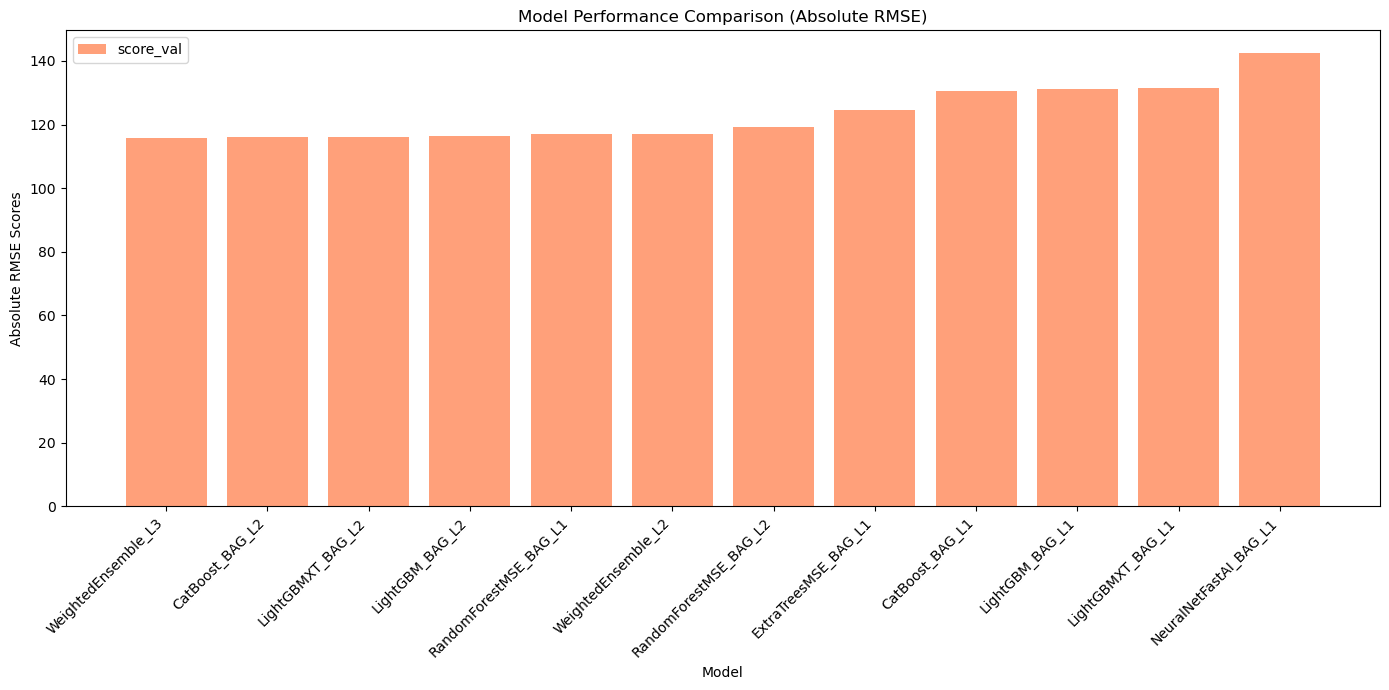

In [28]:
import matplotlib.pyplot as plt

# Assuming 'leaderboard_df' is your DataFrame
models = leaderboard_df['model']
scores = leaderboard_df['score_val']

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the bars using absolute scores and 'lightsalmon' color
# We use abs() to ensure the bars plot upwards from 0
ax.bar(
    models, 
    scores.abs(),  
    color='lightsalmon'
)

# Set X-axis labels and rotate them for readability
ax.set_xlabel("Model")
ax.set_ylabel("Absolute RMSE Scores")
ax.set_title("Model Performance Comparison (Absolute RMSE)")
plt.xticks(rotation=45, ha='right')
ax.legend(['score_val']) 

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

### Create predictions from test dataset

In [29]:
predictions = predictor.predict(test)
predictions.head()

0    81.708847
1    81.196259
2    81.196259
3    95.865479
4    95.865479
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [30]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      218.833374
std       126.564674
min        15.593138
25%       120.412399
50%       196.542572
75%       302.706543
max       629.248047
Name: count, dtype: float64

In [31]:
# How many negative values do we have?
# Since the minimum value is 15.593138 we can safely assume that there are not negative values 
# but still if we have to verify
total_predictions_count = len(predictions)
pred_Ncount = (predictions < 0).sum()
pred_Pcount = (predictions >= 0).sum()

print("Total predictions                :", total_predictions_count)
print("Total positive prediction values :", pred_Pcount)
print("Total negative prediction values :", pred_Ncount)

Total predictions                : 6493
Total positive prediction values : 6493
Total negative prediction values : 0


In [32]:
# Set them to zero
# guardrails incase there are negative values
predictions[predictions < 0] = 0

# Check for any remaining negative values
predictions_neg_count = (predictions < 0).sum()

print(f"Number of remaining negative predictions: {predictions_neg_count}")
print("All negative values have been successfully clipped to zero.")

Number of remaining negative predictions: 0
All negative values have been successfully clipped to zero.


### Set predictions to submission dataframe, save, and submit

In [33]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [34]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 620kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [37]:
!pip install --upgrade kaggle

In [41]:

!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 7, in <module>
    sys.exit(main())
             ^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/kaggle/cli.py", line 70, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/kaggle/api/kaggle_api_extended.py", line 1467, in competition_submissions_cli
    submissions = self.competition_submissions(
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: KaggleApi.competition_submissions() got an unexpected keyword argument 'page_number'


In [42]:
!kaggle --version

Kaggle API 1.8.2


In [64]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
subs = api.competition_submissions('bike-sharing-demand')  # no page_number
import json

for s in subs[:3]:
    print(json.dumps(vars(s), indent=2, sort_keys=True, default=str))
    print("-" * 40)

{
  "_date": "2025-12-07 16:00:57.423000",
  "_description": "first raw submission",
  "_error_description": null,
  "_file_name": "submission.csv",
  "_is_frozen": true,
  "_private_score": "1.42139",
  "_public_score": "1.42139",
  "_ref": 48843618,
  "_status": "SubmissionStatus.COMPLETE",
  "_submitted_by": "brejeshbalakrishnan",
  "_submitted_by_ref": "brejeshbalakrishnan",
  "_team_name": "Brejesh Balakrishnan",
  "_total_bytes": 192955,
  "_url": "/submissions/48843618/48843618.raw"
}
----------------------------------------


#### Initial score of `1.42139`

## Step 4: Exploratory Data Analysis and Creating an additional feature
* Any additional feature will do, but a great suggestion would be to separate out the datetime into hour, day, or month parts.

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'casual'}>,
        <Axes: title={'center': 'registered'}>,
        <Axes: title={'center': 'count'}>]], dtype=object)

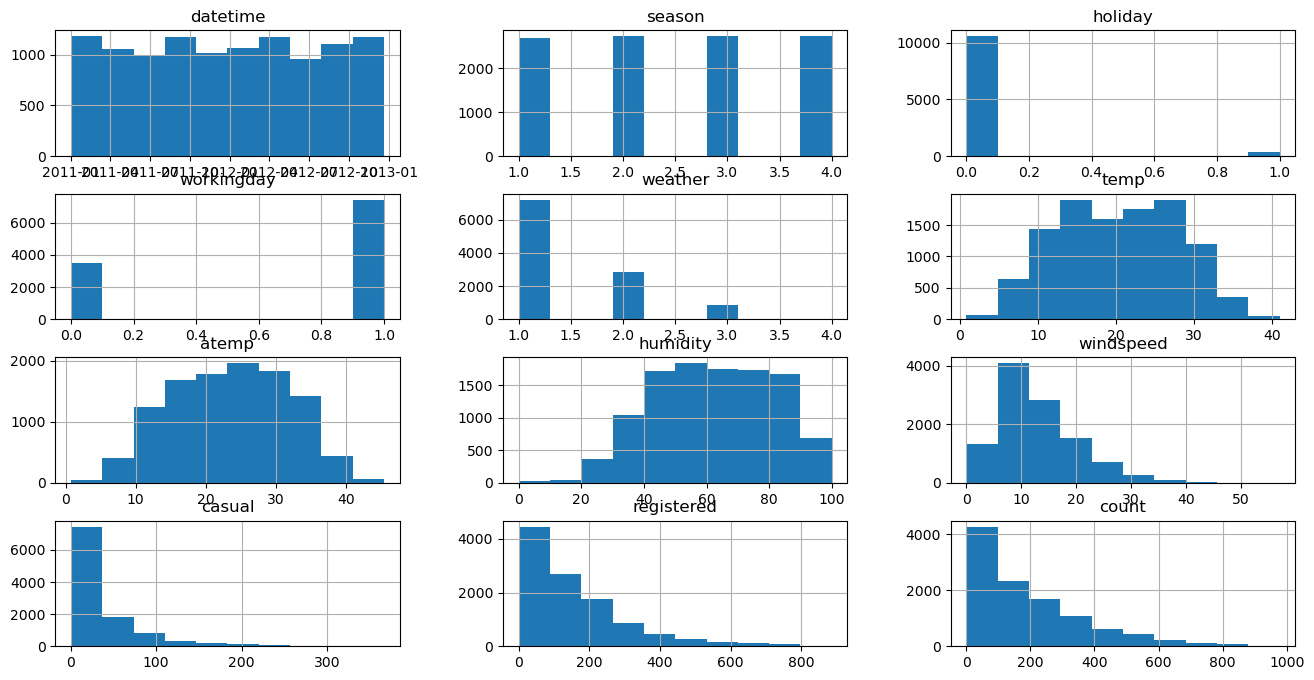

In [66]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(16,8))

#### Plot Heatmap using Correlation Matrix

<Figure size 1800x1800 with 0 Axes>

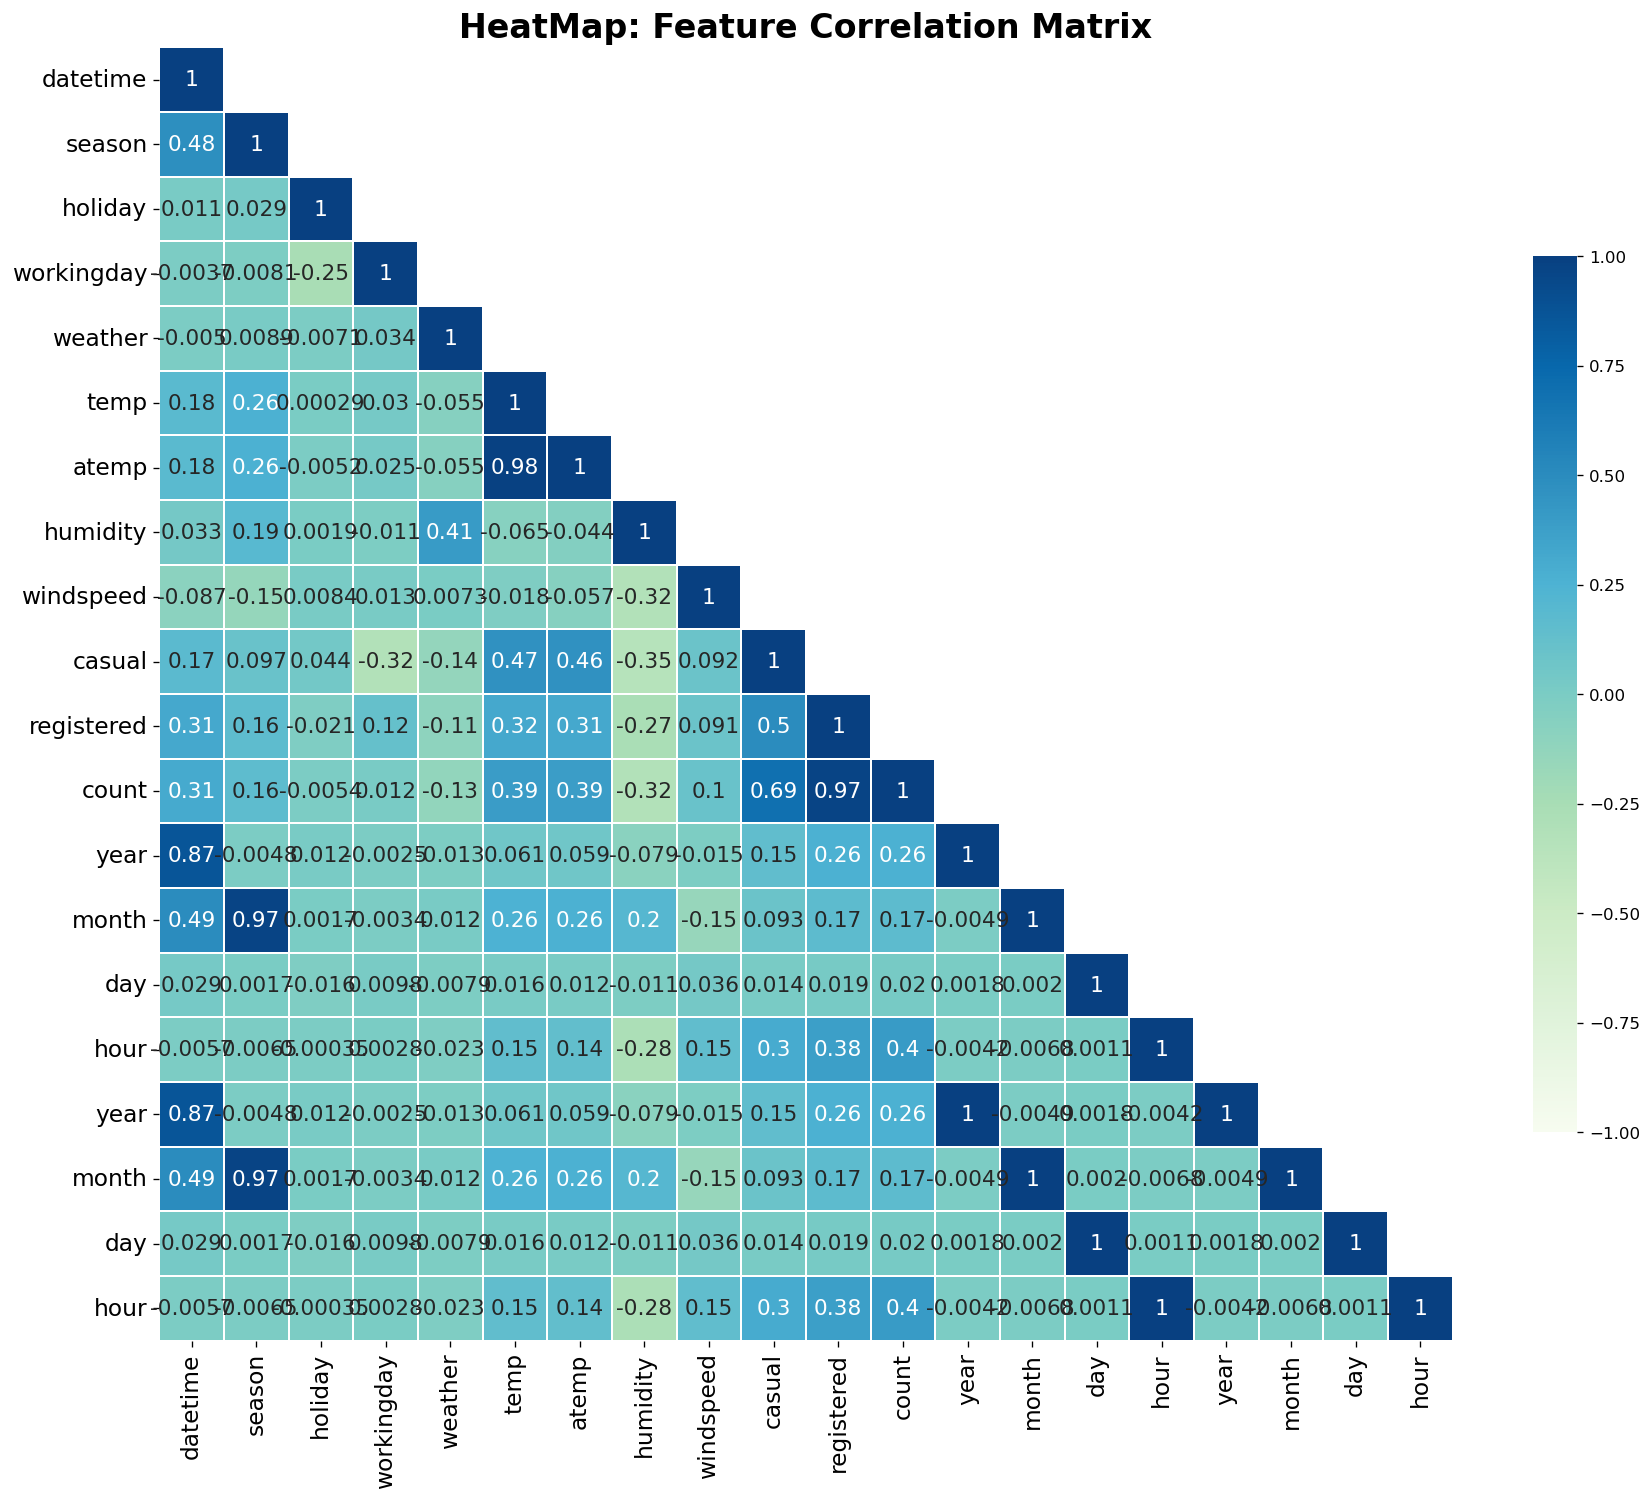

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(15, 15), dpi=120)
corr_data = train.copy()
correlation_matrix = corr_data.corr()
figure_plot, axes_heatmap = plt.subplots(figsize=(15, 15), dpi=120)
upper_triangle_mask = np.array(correlation_matrix)
upper_triangle_mask[np.tril_indices_from(upper_triangle_mask)] = False
axes_heatmap = sns.heatmap(correlation_matrix, cmap='GnBu', cbar_kws={"shrink": .5}, vmin=-1, vmax=1, center=0,
            square=True, mask=upper_triangle_mask, annot=True, linewidths=0.01, annot_kws={"size":13})
plt.xticks(fontsize=14, rotation=90)
plt.yticks(fontsize=14, rotation=0)
plt.title("HeatMap: Feature Correlation Matrix", fontsize=20, fontweight='bold')
plt.tight_layout()
plt.autoscale()
plt.show()

In [68]:
# create a new feature
train = pd.concat([train,pd.DataFrame({
                     'year' : train.datetime.dt.year, 
                     'month': train.datetime.dt.month,
                     'day': train.datetime.dt.day,
                     'hour': train.datetime.dt.hour})],axis=1)
test = pd.concat([test,pd.DataFrame({
                     'year' : test.datetime.dt.year, 
                     'month': test.datetime.dt.month,
                     'day': test.datetime.dt.day,
                     'hour': test.datetime.dt.hour})],axis=1)

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [75]:
# Recheck datatype of features in the train dataset
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  month       10886 non-null  int32         
 14  day         10886 non-null  int32         
 15  hour        10886 non-null  int32         
 16  year        10886 non-

In [69]:
train["season"] = train.season.astype('category')
train["weather"] = train.weather.astype('category')
test["season"] = test.season.astype('category')
test["weather"] = test.weather.astype('category')

In [70]:
# View are new feature
train.head()

datetime season  holiday  workingday weather  temp   atemp  \
0 2011-01-01 00:00:00      1        0           0       1  9.84  14.395   
1 2011-01-01 01:00:00      1        0           0       1  9.02  13.635   
2 2011-01-01 02:00:00      1        0           0       1  9.02  13.635   
3 2011-01-01 03:00:00      1        0           0       1  9.84  14.395   
4 2011-01-01 04:00:00      1        0           0       1  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month  day  hour  \
0        81        0.0       3          13     16  2011      1    1     0   
1        80        0.0       8          32     40  2011      1    1     1   
2        80        0.0       5          27     32  2011      1    1     2   
3        75        0.0       3          10     13  2011      1    1     3   
4        75        0.0       0           1      1  2011      1    1     4   

   year  month  day  hour  
0  2011      1    1     0  
1  2011      1    1     1  
2  2011      1    1     2  
3  2011      1    1     3  
4  2011      1    1     4

In [73]:
# View histogram of all features again now with the hour feature
train.head()

datetime season  holiday  workingday weather  temp   atemp  \
0 2011-01-01 00:00:00      1        0           0       1  9.84  14.395   
1 2011-01-01 01:00:00      1        0           0       1  9.02  13.635   
2 2011-01-01 02:00:00      1        0           0       1  9.02  13.635   
3 2011-01-01 03:00:00      1        0           0       1  9.84  14.395   
4 2011-01-01 04:00:00      1        0           0       1  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month  day  hour  \
0        81        0.0       3          13     16  2011      1    1     0   
1        80        0.0       8          32     40  2011      1    1     1   
2        80        0.0       5          27     32  2011      1    1     2   
3        75        0.0       3          10     13  2011      1    1     3   
4        75        0.0       0           1      1  2011      1    1     4   

   year  month  day  hour  
0  2011      1    1     0  
1  2011      1    1     1  
2  2011      1    1     2  
3  2011      1    1     3  
4  2011      1    1     4

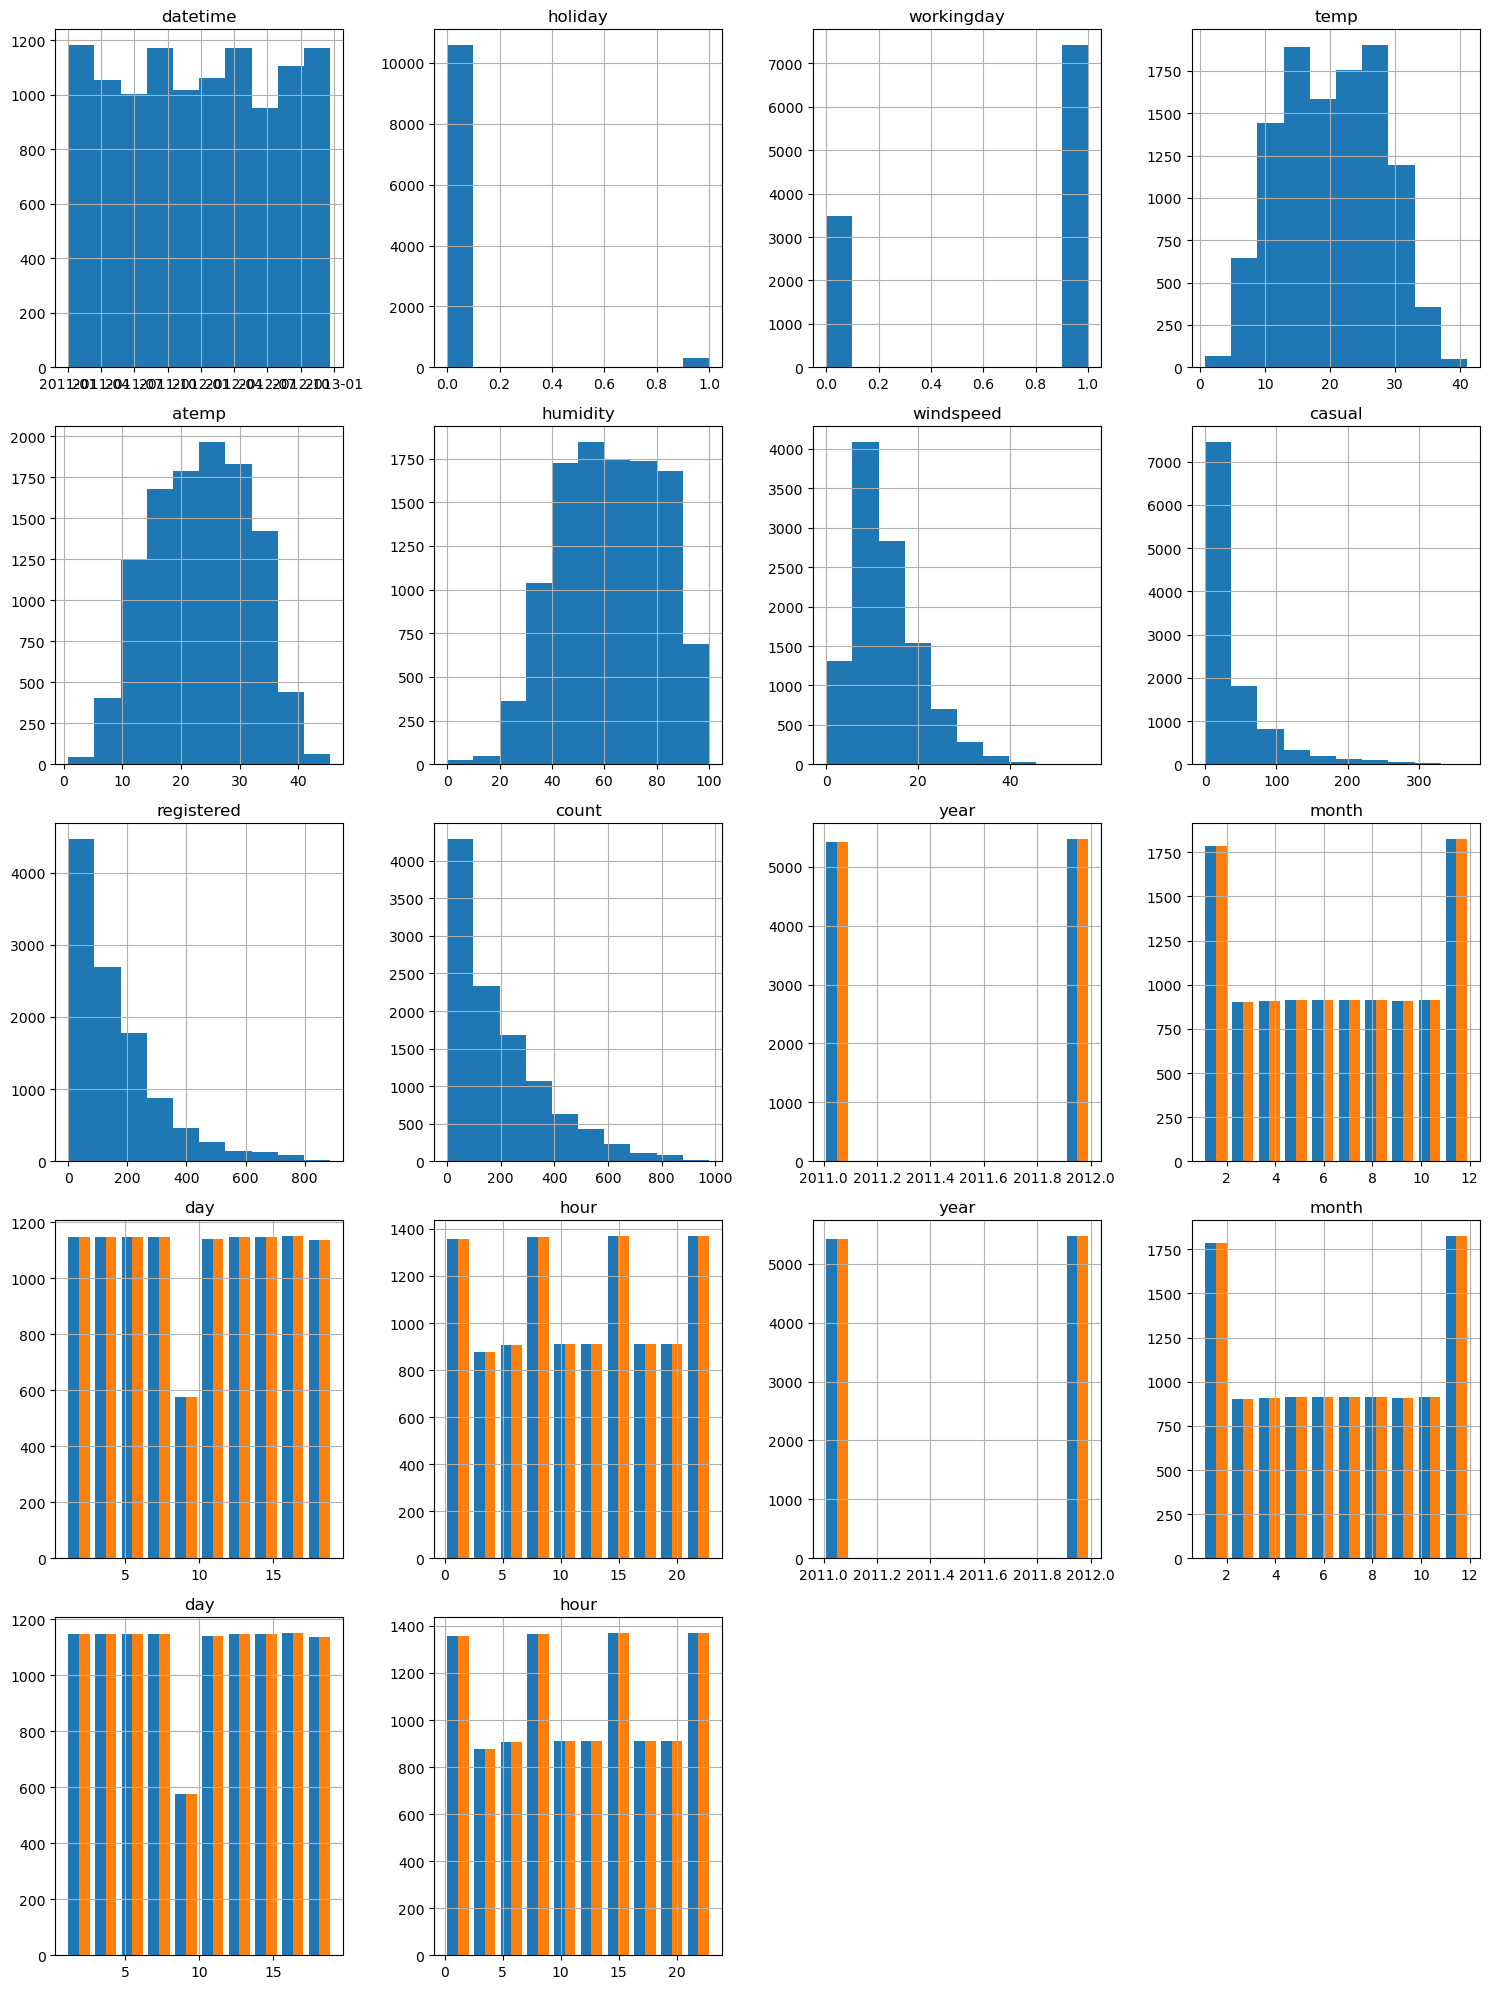

In [76]:
# View histogram of all features again now with the hour feature
train.hist(figsize=(15,20))  # Note: 'casual' and 'registered' are ignored during training as they are absent in test data

plt.tight_layout()
plt.show()

## Step 5: Rerun the model with the same settings as before, just with more features

In [80]:
predictor_new_features = TabularPredictor(label=label, 
                                          problem_type= 'regression',
                                          eval_metric=eval_metric, 
                                          learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                                           train_data = train_data,
                                                                                           time_limit=time_limit,
                                                                                           presets=presets,
                                                                                           dynamic_stacking=False,  # Turn off the heavy memory check
                                                                                           num_stack_levels=0)

No path specified. Models will be saved in: "AutogluonModels/ag-20251207_163323"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Mon Nov  3 18:38:36 UTC 2025
CPU Count:          2
Memory Avail:       0.44 GB / 3.74 GB (11.8%)
Disk Space Avail:   4.16 GB / 4.99 GB (83.4%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/home/sagemaker-user/udacity-AWS-ml-engineer-nanodegree/project/AutogluonModels/ag-20251207_163323"
Train Data Rows:    10886
Train Data Columns: 11
Label Column:       count
Problem Ty

In [81]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                    model   score_val              eval_metric  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0     WeightedEnsemble_L2 -119.918835  root_mean_squared_error       0.293488  372.804507                0.000870           0.045973            2       True          8
1  RandomForestMSE_BAG_L1 -120.169502  root_mean_squared_error       0.210456    2.440768                0.210456           2.440768            1       True          3
2    ExtraTreesMSE_BAG_L1 -128.125420  root_mean_squared_error       0.129230    1.044748                0.129230           1.044748            1       True          5
3         CatBoost_BAG_L1 -130.472284  root_mean_squared_error       0.070377  313.350754                0.070377         313.350754            1       True          4
4    CatBoost_r177_BAG_L1 -131.184374  root_mean_squared_error       0.044790   83.423699         

{'model_types': {'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'CatBoost_r177_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel'},
 'model_performance': {'LightGBMXT_BAG_L1': -178.751832961977,
  'LightGBM_BAG_L1': -177.94493629824913,
  'RandomForestMSE_BAG_L1': -120.16950217387324,
  'CatBoost_BAG_L1': -130.4722836190554,
  'ExtraTreesMSE_BAG_L1': -128.12541992122735,
  'LightGBMLarge_BAG_L1': -178.94068408417186,
  'CatBoost_r177_BAG_L1': -131.18437390585132,
  'WeightedEnsemble_L2': -119.91883528766368},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'LightGBMXT_BAG_L1': ['LightGBMXT_BAG_L1'],
  'LightGBM_BAG_L1': ['LightGBM_BAG_L1'],
  'RandomForestMSE_BAG_L1': ['Rando

In [82]:
# Leaderboard dataframe
leaderboard_new_features_df = pd.DataFrame(predictor_new_features.leaderboard(silent=True))
leaderboard_new_features_df

model   score_val              eval_metric  pred_time_val  \
0     WeightedEnsemble_L2 -119.918835  root_mean_squared_error       0.293488   
1  RandomForestMSE_BAG_L1 -120.169502  root_mean_squared_error       0.210456   
2    ExtraTreesMSE_BAG_L1 -128.125420  root_mean_squared_error       0.129230   
3         CatBoost_BAG_L1 -130.472284  root_mean_squared_error       0.070377   
4    CatBoost_r177_BAG_L1 -131.184374  root_mean_squared_error       0.044790   
5         LightGBM_BAG_L1 -177.944936  root_mean_squared_error       0.010209   
6       LightGBMXT_BAG_L1 -178.751833  root_mean_squared_error       0.011785   
7    LightGBMLarge_BAG_L1 -178.940684  root_mean_squared_error       0.013571   

     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  \
0  372.804507                0.000870           0.045973            2   
1    2.440768                0.210456           2.440768            1   
2    1.044748                0.129230           1.044748            1   
3  313.350754                0.070377         313.350754            1   
4   83.423699                0.044790          83.423699            1   
5   53.146978                0.010209          53.146978            1   
6   56.967011                0.011785          56.967011            1   
7   53.875580                0.013571          53.875580            1   

   can_infer  fit_order  
0       True          8  
1       True          3  
2       True          5  
3       True          4  
4       True          7  
5       True          2  
6       True          1  
7       True          6

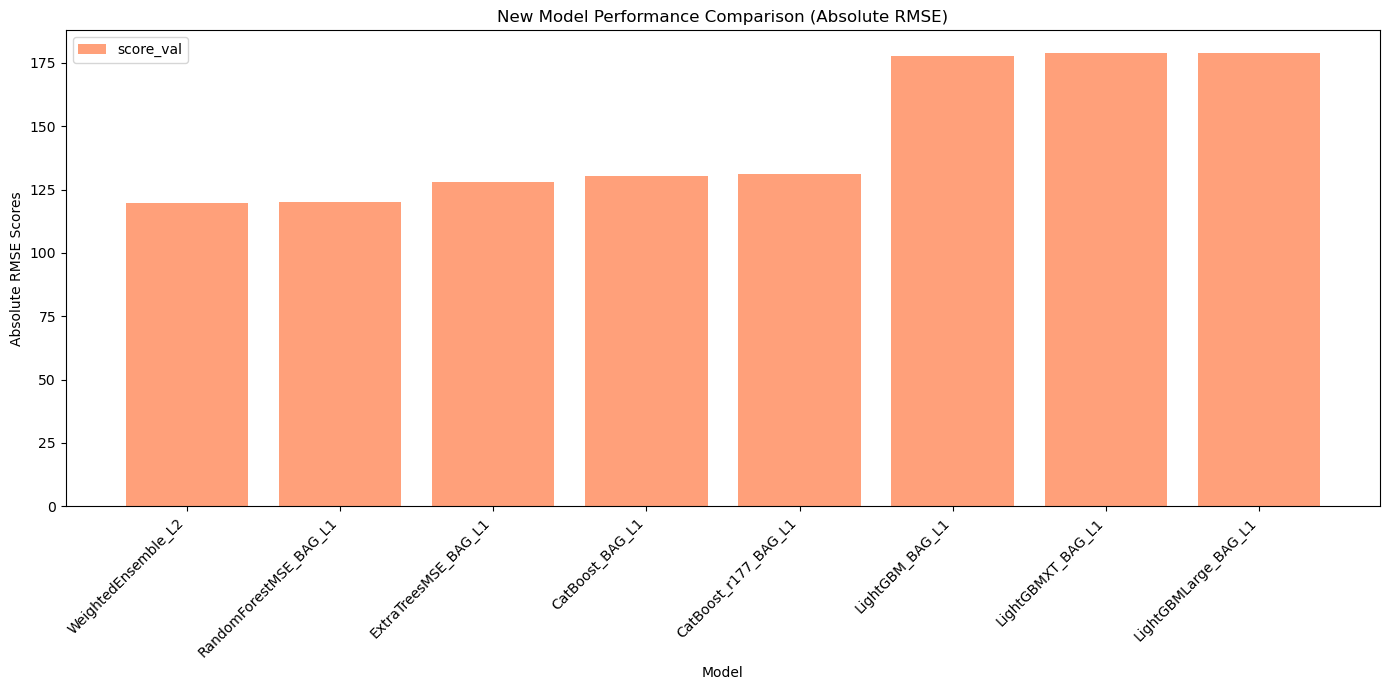

In [83]:
# Assuming 'leaderboard_df' is your DataFrame
models = leaderboard_new_features_df['model']
scores = leaderboard_new_features_df['score_val']

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the bars using absolute scores and 'lightsalmon' color
# We use abs() to ensure the bars plot upwards from 0
ax.bar(
    models, 
    scores.abs(),  
    color='lightsalmon'
)

# Set X-axis labels and rotate them for readability
ax.set_xlabel("Model")
ax.set_ylabel("Absolute RMSE Scores")
ax.set_title("New Model Performance Comparison (Absolute RMSE)")
plt.xticks(rotation=45, ha='right')
ax.legend(['score_val']) 

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [84]:
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features.head()

0    90.126976
1    75.239059
2    75.239059
3    89.350655
4    89.350655
Name: count, dtype: float32

In [85]:
# Remember to set all negative values to zero
predictions_new_features.describe()

count    6493.000000
mean      217.399445
std       126.659805
min        17.851311
25%       120.187096
50%       188.148270
75%       292.530701
max       686.759705
Name: count, dtype: float64

In [86]:
predictions_new_features[predictions_new_features<0] = 0    # (In case, if negative values exist in the predictions_new_features, set them to 0)

# Rechecking, if no predictions are less than 0
negative_pred_count = predictions_new_features.apply(lambda x: 1 if x<0 else 0)
pred_neg_count = (negative_pred_count==1).sum()
print(f"No. of negative predictions: {pred_neg_count}")
print("All negative values in the predictions (if any) are set to zero successfully.")

No. of negative predictions: 0
All negative values in the predictions (if any) are set to zero successfully.


In [95]:
predictions_new_features.head()

0    90.126976
1    75.239059
2    75.239059
3    89.350655
4    89.350655
Name: count, dtype: float32

In [97]:
submission_new_features = pd.read_csv('sampleSubmission.csv', parse_dates=["datetime"])
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [98]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 669kB/s]
Successfully submitted to Bike Sharing Demand

In [99]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
subs = api.competition_submissions('bike-sharing-demand')  # no page_number
import json

for s in subs[0:3]:
    print(json.dumps(vars(s), indent=2, sort_keys=True, default=str))
    print("-" * 40)

{
  "_date": "2025-12-07 16:48:56.703000",
  "_description": "new features",
  "_error_description": null,
  "_file_name": "submission_new_features.csv",
  "_is_frozen": true,
  "_private_score": "1.41560",
  "_public_score": "1.41560",
  "_ref": 48844886,
  "_status": "SubmissionStatus.COMPLETE",
  "_submitted_by": "brejeshbalakrishnan",
  "_submitted_by_ref": "brejeshbalakrishnan",
  "_team_name": "Brejesh Balakrishnan",
  "_total_bytes": 192883,
  "_url": "/submissions/48844886/48844886.raw"
}
----------------------------------------
{
  "_date": "2025-12-07 16:45:44.443000",
  "_description": "new features",
  "_error_description": null,
  "_file_name": "submission_new_features.csv",
  "_is_frozen": true,
  "_private_score": "1.41560",
  "_public_score": "1.41560",
  "_ref": 48844797,
  "_status": "SubmissionStatus.COMPLETE",
  "_submitted_by": "brejeshbalakrishnan",
  "_submitted_by_ref": "brejeshbalakrishnan",
  "_team_name": "Brejesh Balakrishnan",
  "_total_bytes": 192883,
  "_

#### New Score of `1.41560`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [157]:
import autogluon.core as ag
from autogluon.common import space 


# Define the dictionary for the GBMLarge preset
gbm_large_preset = {
    "learning_rate": 0.03,
    "num_leaves": 128,
    "feature_fraction": 0.9,
    "min_data_in_leaf": 3,
    # Priority 0 ensures it doesn't interfere with your custom HPO trial priority
    "ag_args": {"name_suffix": "Large", "priority": 0, "hyperparameter_tune_kwargs": None}, 
}

# Exclude ['NN_TORCH'] family of models
excluded_model_types = ['NN_TORCH']

# For GBM
gbm_options = [
    { # Custom HPO Trial Configuration
        'extra_trees': True,
        'num_boost_round': space.Int(lower=100, upper=800, default=100),
        'num_leaves': space.Int(lower=26, upper=66, default=36),
        'ag_args': {'name_suffix': 'XT'}
    }, 
    {}, # Default Configuration (to train a baseline GBM)
    gbm_large_preset # ⬅️ FIX: Use the dictionary instead of the string 'GBMLarge'
]

# XT Models
xt_options = {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}}

# XGB Models
xgb_options = [{'objective': 'reg:squarederror', 
                'eval_metric': 'rmse',
                'max_depth': space.Int(lower=5, upper=8, default=6), 
                'n_estimators': space.Int(lower=100, upper=500, default=100), 
                'eta': .3,
                'subsample': 1,
                'colsample_bytree': 1}]

hyperparameters = {
    'GBM': gbm_options,
    'XT': xt_options,
    'XGB': xgb_options
}

num_trials = 20
search_strategy = 'auto'
scheduler = 'local'

hyperparameter_tune_kwargs = {
                             'num_trials': num_trials,
                             'scheduler' : scheduler,
                             'searcher': search_strategy,
                             }

In [110]:
predictor_new_hpo = TabularPredictor(label='count', problem_type='regression', eval_metric='root_mean_squared_error',
                                    learner_kwargs={'ignored_columns': ignored_columns}).fit(
                                                                         train_data=train, 
                                                                         time_limit=time_limit,
                                                                         presets=presets, 
                                                                         hyperparameters=hyperparameters, 
                                                                         hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                         excluded_model_types=excluded_model_types,
                                                                         refit_full='best',
                                                                                           dynamic_stacking=False,  # Turn off the heavy memory check
                                                                                           num_stack_levels=0)

No path specified. Models will be saved in: "AutogluonModels/ag-20251207_170115"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.12.9
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Mon Nov  3 18:38:36 UTC 2025
CPU Count:          2
Memory Avail:       0.44 GB / 3.74 GB (11.6%)
Disk Space Avail:   4.01 GB / 4.99 GB (80.3%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=8, num_bag_sets=1
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/home/sagemaker-user/udacity-AWS-ml-engineer-nanodegree/project/AutogluonModels/ag-20251207_170115"
Train Data Rows:    10886
Train Data Columns: 19
Label Column:       count
Problem Type:       regression
Preprocessing data ...
Using Feature

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=1.86%)
Task was killed due to the node running low on memory.
Memory on the node (IP: 169.255.255.2, ID: a44417bdf770811fdb553856390337ca80ba1b487a957487fa0ae87d) where the task (task ID: f96840cb3d6fd8909fd4785627ebb8257532591101000000, name=_ray_fit, pid=13208, memory used=0.10GB) was running was 3.56GB / 3.74GB (0.952415), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 162c8db4a139c7645fc43649d4f71f74fd5e4510496ca1cf6cfd9769) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 169.255.255.2`. To see the logs of the worker, use `ray logs worker-162c8db4a139c7645fc43649d4f71f74fd5e4510496ca1cf6cfd9769*out -ip 169.255.255.2. Top 10 memory users:
PID	MEM(GB)	COMMAND
609	1.23	/opt/conda/bin/python -m ipykernel_launcher -f /home/sagemaker-user/.local/sh

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=6.56%)
Task was killed due to the node running low on memory.
Memory on the node (IP: 169.255.255.2, ID: a44417bdf770811fdb553856390337ca80ba1b487a957487fa0ae87d) where the task (task ID: a7a6a3bd625f4deae69b599bced43b0a2e44e46a01000000, name=_ray_fit, pid=14794, memory used=0.05GB) was running was 3.56GB / 3.74GB (0.95309), which exceeds the memory usage threshold of 0.95. Ray killed this worker (ID: 7f26abd71ad1b57de8f08bd18590e4c9132b8729a83faea802d39cd0) because it was the most recently scheduled task; to see more information about memory usage on this node, use `ray logs raylet.out -ip 169.255.255.2`. To see the logs of the worker, use `ray logs worker-7f26abd71ad1b57de8f08bd18590e4c9132b8729a83faea802d39cd0*out -ip 169.255.255.2. Top 10 memory users:
PID	MEM(GB)	COMMAND
609	1.24	/opt/conda/bin/python -m ipykernel_launcher -f /home/sagemaker-user/.local/sha

  0%|          | 0/20 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (2 workers, per: cpus=1, gpus=0, memory=3.51%)
ray::_ray_fit() (pid=15903, ip=169.255.255.2)
  File "/opt/conda/lib/python3.12/site-packages/autogluon/core/models/ensemble/fold_fitting_strategy.py", line 446, in _ray_fit
    fold_model.fit(X=X_fold, y=y_fold, X_val=X_val_fold, y_val=y_val_fold, time_limit=time_limit_fold, **resources, **kwargs_fold)
  File "/opt/conda/lib/python3.12/site-packages/autogluon/core/models/abstract/abstract_model.py", line 1068, in fit
    out = self._fit(**kwargs)
          ^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/autogluon/tabular/models/xgboost/xgboost_model.py", line 171, in _fit
    metric_name=eval_metric_name,  # forces stopping_metric rather than arbitrary last metric
                ^^^^^^^^^^^^^^^^
UnboundLocalError: cannot access local variable 'eval_metric_name' where it is not associated with a value
Traceback (most recent call last)

In [111]:
predictor_new_hpo.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model  score_val              eval_metric  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0       ExtraTreesMSE_BAG_L1 -39.953761  root_mean_squared_error       0.126752  2.411394                0.126752           2.411394            1       True          1
1        WeightedEnsemble_L2 -39.953761  root_mean_squared_error       0.127558  2.418852                0.000806           0.007458            2       True          2
2  ExtraTreesMSE_BAG_L1_FULL        NaN  root_mean_squared_error       0.126752  2.180187                0.126752           2.180187            1       True          3
Number of models trained: 3
Types of models trained:
{'WeightedEnsembleModel', 'StackerEnsembleModel_XT'}
Bagging used: True  (with 8 folds)
Multi-layer stack-ensembling used: False 
Feature Metadata (Processed):
(raw dtype, special dtypes):
('category', [])        

{'model_types': {'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'ExtraTreesMSE_BAG_L1_FULL': 'StackerEnsembleModel_XT'},
 'model_performance': {'ExtraTreesMSE_BAG_L1': -39.953761435872615,
  'WeightedEnsemble_L2': -39.953761435872615,
  'ExtraTreesMSE_BAG_L1_FULL': None},
 'model_best': 'WeightedEnsemble_L2',
 'model_paths': {'ExtraTreesMSE_BAG_L1': ['ExtraTreesMSE_BAG_L1'],
  'WeightedEnsemble_L2': ['WeightedEnsemble_L2'],
  'ExtraTreesMSE_BAG_L1_FULL': ['ExtraTreesMSE_BAG_L1_FULL']},
 'model_fit_times': {'ExtraTreesMSE_BAG_L1': 2.4113941192626953,
  'WeightedEnsemble_L2': 0.0074579715728759766,
  'ExtraTreesMSE_BAG_L1_FULL': 2.180187463760376},
 'model_pred_times': {'ExtraTreesMSE_BAG_L1': 0.12675237655639648,
  'WeightedEnsemble_L2': 0.0008056163787841797,
  'ExtraTreesMSE_BAG_L1_FULL': 0.12675237655639648},
 'num_bag_folds': 8,
 'max_stack_level': 2,
 'model_hyperparams': {'ExtraTreesMSE_BAG_L1': {'use_orig_features': True,
  

In [106]:
# Assuming your DataFrame is named 'train'
duplicated_columns = train.columns[train.columns.duplicated()]

if not duplicated_columns.empty:
    print("❌ ERROR: The following columns are duplicated in your training data:")
    print(duplicated_columns.tolist())
else:
    print("✅ No duplicated columns found. (The error must stem from another manipulation.)")

❌ ERROR: The following columns are duplicated in your training data:
['year', 'month', 'day', 'hour']


In [107]:
cols = train.columns
seen_names = {}
new_cols = []

# Iterate through the columns and append a counter suffix if the name is already seen
for col in cols:
    if col in seen_names:
        seen_names[col] += 1
        new_cols.append(f"{col}_{seen_names[col]}")
    else:
        seen_names[col] = 0
        new_cols.append(col)

train.columns = new_cols
print("Duplicated columns renamed successfully. New columns:", train.columns.tolist())

Duplicated columns renamed successfully. New columns: ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'year', 'month', 'day', 'hour', 'year_1', 'month_1', 'day_1', 'hour_1']


In [141]:
cols = test.columns
seen_names = {}
new_cols = []

# Iterate through the columns and append a counter suffix if the name is already seen
for col in cols:
    if col in seen_names:
        seen_names[col] += 1
        new_cols.append(f"{col}_{seen_names[col]}")
    else:
        seen_names[col] = 0
        new_cols.append(col)

test.columns = new_cols
print("Duplicated columns renamed successfully. New columns:", test.columns.tolist())

Duplicated columns renamed successfully. New columns: ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'year_1', 'month_1', 'day_1', 'hour_1']


In [113]:
# Leaderboard dataframe
leaderboard_new_hpo1_df = pd.DataFrame(predictor_new_hpo.leaderboard(silent=True))
leaderboard_new_hpo1_df

model  score_val              eval_metric  \
0       ExtraTreesMSE_BAG_L1 -39.953761  root_mean_squared_error   
1        WeightedEnsemble_L2 -39.953761  root_mean_squared_error   
2  ExtraTreesMSE_BAG_L1_FULL        NaN  root_mean_squared_error   

   pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  \
0       0.126752  2.411394                0.126752           2.411394   
1       0.127558  2.418852                0.000806           0.007458   
2       0.126752  2.180187                0.126752           2.180187   

   stack_level  can_infer  fit_order  
0            1       True          1  
1            2       True          2  
2            1       True          3

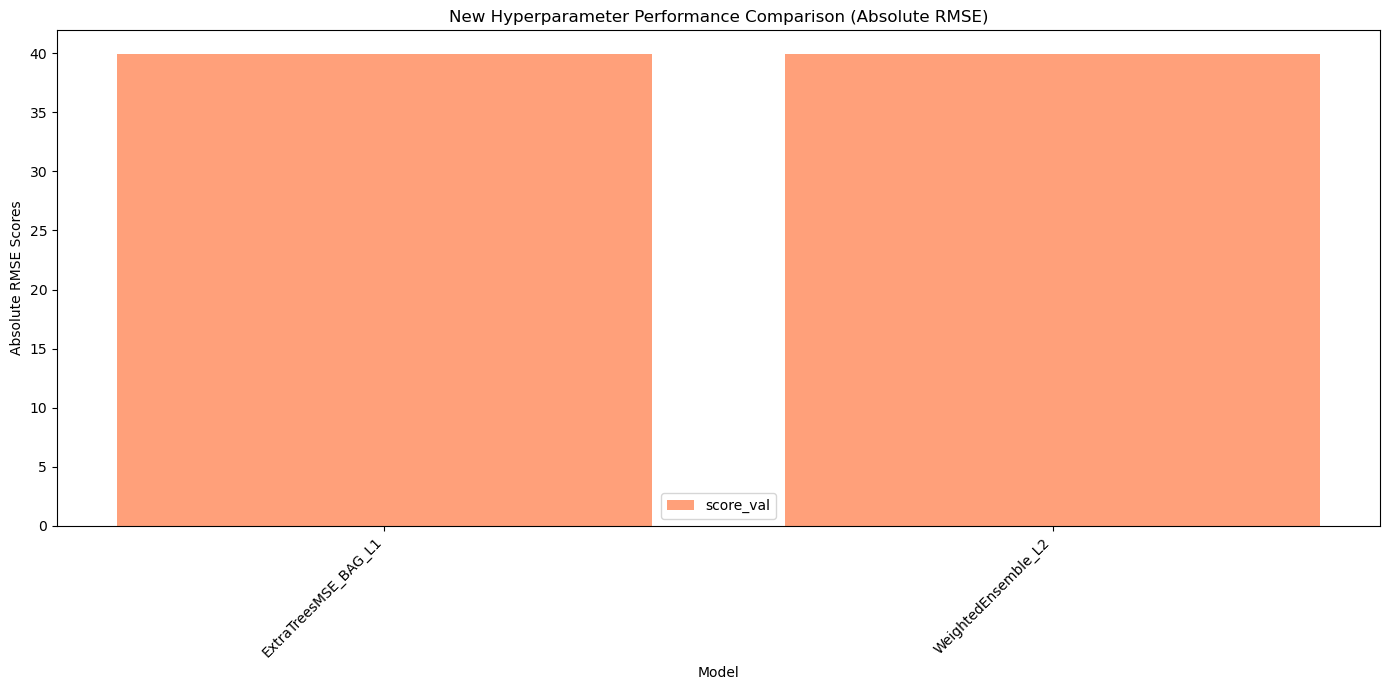

In [136]:
# Assuming 'leaderboard_df' is your DataFrame
models = leaderboard_new_hpo1_df['model']
scores = leaderboard_new_hpo1_df['score_val']

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the bars using absolute scores and 'lightsalmon' color
# We use abs() to ensure the bars plot upwards from 0
ax.bar(
    models, 
    scores.abs(),  
    color='lightsalmon'
)

# Set X-axis labels and rotate them for readability
ax.set_xlabel("Model")
ax.set_ylabel("Absolute RMSE Scores")
ax.set_title("New Hyperparameter Performance Comparison (Absolute RMSE)")
plt.xticks(rotation=45, ha='right')
ax.legend(['score_val']) 

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

In [135]:
from autogluon.tabular import TabularPredictor

# after fitting predictor_new_hpo
feature_metadata = predictor_new_hpo.feature_metadata
original_features = feature_metadata.get_features()

print("✅ Successfully Retrieved Expected Input Features (Original Columns):")
print(original_features)

✅ Successfully Retrieved Expected Input Features (Original Columns):
['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'season', 'weather', 'datetime', 'datetime.year', 'datetime.dayofweek']


In [145]:
print("Train Columns: ",train.columns.tolist())
print("Test Columns: ",test.columns.tolist())

Train Columns:  ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count', 'year', 'month', 'day', 'hour', 'year_1', 'month_1', 'day_1', 'hour_1']
Test Columns:  ['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour', 'year_1', 'month_1', 'day_1', 'hour_1']


In [146]:
import pandas as pd

# 1. Ensure 'datetime' is of datetime type (as done in the previous step)
test['datetime'] = pd.to_datetime(test['datetime'])

# 2. Manually engineer the features AG is expecting as raw input
test['datetime.year'] = test['datetime'].dt.year
test['datetime.dayofweek'] = test['datetime'].dt.dayofweek

# 3. Define the final features list (the 15 columns AG expects)
expected_features_to_keep = [
    'holiday', 'workingday', 'temp', 'atemp', 'humidity', 
    'windspeed', 'year', 'month', 'day', 'hour', 
    'season', 'weather', 'datetime', 'datetime.year', 'datetime.dayofweek'
]

# 4. Filter the test data to include ONLY the 15 expected columns, in order
test_final = test[expected_features_to_keep]

print(f"Test data final columns: {len(test_final.columns)}")

Test data final columns: 15


In [147]:
predictions_new_hpo = predictor_new_hpo.predict(test_final) 

print("\nPrediction successful! 🎉")
print(predictions_new_hpo.head())


Prediction successful! 🎉
0    11.983606
1     5.639344
2     3.721312
3     3.442623
4     2.573771
Name: count, dtype: float32


In [149]:
# Remember to set all negative values to zero
# guardrails incase there are negative values
predictions_new_hpo[predictions_new_hpo < 0] = 0

# Check for any remaining negative values
predictions_neg_count = (predictions_new_hpo < 0).sum()

print(f"Number of remaining negative predictions: {predictions_neg_count}")
print("All negative values have been successfully clipped to zero.")

Number of remaining negative predictions: 0
All negative values have been successfully clipped to zero.


In [150]:
# Same submitting predictions
submission_new_hpo = pd.read_csv('sampleSubmission.csv', parse_dates = ['datetime'])
submission_new_hpo["count"] = predictions_new_hpo
submission_new_hpo.to_csv("submission_new_hpo.csv", index=False)

In [151]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo.csv -m "new features with hyperparameters"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 688kB/s]
Successfully submitted to Bike Sharing Demand

In [152]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()
subs = api.competition_submissions('bike-sharing-demand')  # no page_number
import json

for s in subs[0:3]:
    print(json.dumps(vars(s), indent=2, sort_keys=True, default=str))
    print("-" * 40)

{
  "_date": "2025-12-07 17:31:52.367000",
  "_description": "new features with hyperparameters",
  "_error_description": null,
  "_file_name": "submission_new_hpo.csv",
  "_is_frozen": true,
  "_private_score": "0.49145",
  "_public_score": "0.49145",
  "_ref": 48845897,
  "_status": "SubmissionStatus.COMPLETE",
  "_submitted_by": "brejeshbalakrishnan",
  "_submitted_by_ref": "brejeshbalakrishnan",
  "_team_name": "Brejesh Balakrishnan",
  "_total_bytes": 192435,
  "_url": "/submissions/48845897/48845897.raw"
}
----------------------------------------
{
  "_date": "2025-12-07 16:48:56.703000",
  "_description": "new features",
  "_error_description": null,
  "_file_name": "submission_new_features.csv",
  "_is_frozen": true,
  "_private_score": "1.41560",
  "_public_score": "1.41560",
  "_ref": 48844886,
  "_status": "SubmissionStatus.COMPLETE",
  "_submitted_by": "brejeshbalakrishnan",
  "_submitted_by_ref": "brejeshbalakrishnan",
  "_team_name": "Brejesh Balakrishnan",
  "_total_byte

#### New Score of `0.49145`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

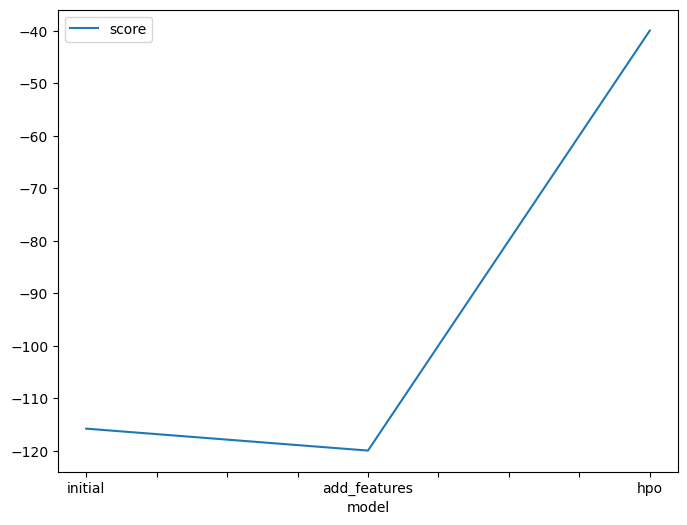

In [153]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo"],
        "score": [predictor.leaderboard().loc[0,'score_val'], 
            predictor_new_features.leaderboard().loc[0,'score_val'], 
            predictor_new_hpo.leaderboard().loc[0,'score_val']]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

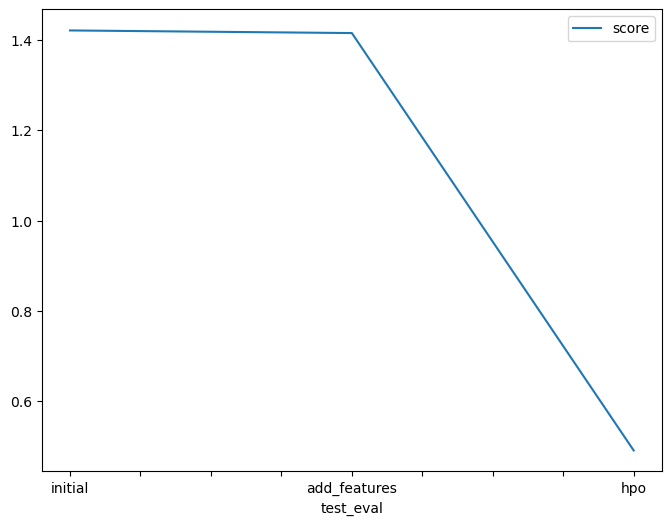

In [154]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo"],
        "score": [1.42139, 1.4156, 0.49145]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')

### Hyperparameter table

In [158]:
# The 3 hyperparameters we tuned with the kaggle score as the result
pd.DataFrame({
    "model": ["initial", "add_features", "hpo"],
    "XT": ['default', 'default', xt_options ],
    "GBM": ['default', 'default', gbm_options],
    "XGB": ['default', 'default', xgb_options ],
    "score": [1.42139, 1.4156, 0.49145]
})

model  \
0       initial   
1  add_features   
2           hpo   

                                                                                                   XT  \
0                                                                                             default   
1                                                                                             default   
2  {'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}}   

                                                                                                                                                                                                                                                                                                                                      GBM  \
0                                                                                                                                                                                                                                                                                                                                 default   
1                                                                                                                                                                                                                                                                                                                                 default   
2  [{'extra_trees': True, 'num_boost_round': Int: lower=100, upper=800, 'num_leaves': Int: lower=26, upper=66, 'ag_args': {'name_suffix': 'XT'}}, {}, {'learning_rate': 0.03, 'num_leaves': 128, 'feature_fraction': 0.9, 'min_data_in_leaf': 3, 'ag_args': {'name_suffix': 'Large', 'priority': 0, 'hyperparameter_tune_kwargs': None}}]   

                                                                                                                                                                                            XGB  \
0                                                                                                                                                                                       default   
1                                                                                                                                                                                       default   
2  [{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'max_depth': Int: lower=5, upper=8, 'n_estimators': Int: lower=100, upper=500, 'eta': 0.3, 'subsample': 1, 'colsample_bytree': 1}]   

     score  
0  1.42139  
1  1.41560  
2  0.49145

### Conclusion
The best model was **ExtraTreesMSE_BAG_L1** obtained during the hyperparameter tuning with a RMSE score of **39.953761** and the best kaggle score of **0.49145**